# Complete Code

In [1]:
import pandas as pd
import numpy as np
import dash
from dash import html
from dash import dcc
import plotly.express as px
from jupyter_dash import JupyterDash
from dash.dependencies import Output, Input, State
from ipyfilechooser import FileChooser

# Select file
fc = FileChooser()
# Import GUL data
print('LTE data is importing...')
L = pd.read_excel(fc, sheet_name='LTE', na_values=['NIL','\0'], engine='openpyxl')
print('LTE data is imported. UMTS data is importing...')
U = pd.read_excel(fc, sheet_name='UMTS', na_values=['NIL','\0'], engine='openpyxl')
print('UMTS data is imported. GSM data is importing...')
G = pd.read_excel(fc, sheet_name='GSM', na_values=['NIL','\0'], engine='openpyxl')
print('All GUL data is imported...')

# GUL data manipulation
G['DateTime'] = pd.to_datetime(G['Date'] +' ' + G['Time'])
U['DateTime'] = pd.to_datetime(U['Date'] +' ' + U['Time'])
L['DateTime'] = pd.to_datetime(L['Date'] +' ' + L['Time'])
G['Date'] = pd.to_datetime(G['Date']).dt.date
U['Date'] = pd.to_datetime(U['Date']).dt.date
L['Date'] = pd.to_datetime(L['Date']).dt.date
G['Region'] = G['GCell Group'].str[2::]
U['Region'] = U['UCell Group'].str[2::]
L['Region'] = L['LTE Cell Group'].str[2::]
G = G[(G['TR373:Cell Availability(%)'] != 'NIL') & (G['TR373:Cell Availability(%)'] != 0)]
G = G.replace(np.nan, 0)
U = U[(U['Cell Availability(%)'] != 'NIL') & (U['Cell Availability(%)'] != 0)]
U = U.replace(np.nan, 0)
L = L[(L['Cell Availability(%)'] != 'NIL') & (L['Cell Availability(%)'] != 0)]
L = L.replace(np.nan, 0)
L = L.replace('NIL', 0)
L = L.replace('/0', 0)
G['Interference Band[4-5]%'] = G['Interference Band[4-5]%'].astype('float')
L= L.astype({'L.UL.Interference.Avg(dBm)':'float', 'Intra-freq HOSR (%)':'float'})
print('GUL data wrangling is completed...')

def gsm_gp(df):

    wnd = df.groupby('Date') ['TR373:Cell Availability(%)', 'CS Traffic (Erl)', 'PS Traffic (MB)', 'Interference Band[4-5]%',
                              'Mute Call Counts', 'CS SSR (%)', 'PS CSSR (%)(%)', 'GSM Utilization(%)', 'VAMOS Traffic(Erl)',
                              'GSM TCH Congestion Rate(%)', 'SDCCH Cong Rate (%)(%)'].mean().reset_index()
    wnh = df.groupby('DateTime') ['TR373:Cell Availability(%)', 'CS Traffic (Erl)', 'PS Traffic (MB)', 'Interference Band[4-5]%',
                                   'Mute Call Counts', 'CS SSR (%)', 'PS CSSR (%)(%)', 'GSM Utilization(%)', 'VAMOS Traffic(Erl)',
                                   'GSM TCH Congestion Rate(%)', 'SDCCH Cong Rate (%)(%)'].mean().reset_index()
    rgnd = df.groupby(['Date','Region']) ['TR373:Cell Availability(%)', 'CS Traffic (Erl)', 'PS Traffic (MB)', 'Interference Band[4-5]%',
                                   'Mute Call Counts', 'CS SSR (%)', 'PS CSSR (%)(%)', 'GSM Utilization(%)', 'VAMOS Traffic(Erl)',
                                   'GSM TCH Congestion Rate(%)', 'SDCCH Cong Rate (%)(%)'].mean().reset_index()
    rgnh = df.groupby(['DateTime','Region']) ['TR373:Cell Availability(%)', 'CS Traffic (Erl)', 'PS Traffic (MB)', 'Interference Band[4-5]%',
                                   'Mute Call Counts', 'CS SSR (%)', 'PS CSSR (%)(%)', 'GSM Utilization(%)', 'VAMOS Traffic(Erl)',
                                   'GSM TCH Congestion Rate(%)', 'SDCCH Cong Rate (%)(%)'].mean().reset_index()
    return wnd, wnh, rgnd, rgnh            


def umts_gp(df):

    wnd = df.groupby('Date') ['Cell Availability(%)', 'CS Traffic (Erl)', 'PS Traffic (MB)(MB)', 'VS.MeanRTWP(dBm)', 'Mute Call Counts',
                              'CS Call Setup Success Rate (%)', 'PS Call Setup Success Rate (%)', 'M-Code Congestion(Times)', 'DCH User Numbers',
                              'CS DCR (%)(%)', 'PS DCR (%)(%)'].mean().reset_index()
    wnh = df.groupby('DateTime') ['Cell Availability(%)', 'CS Traffic (Erl)', 'PS Traffic (MB)(MB)', 'VS.MeanRTWP(dBm)', 'Mute Call Counts',
                                  'CS Call Setup Success Rate (%)', 'PS Call Setup Success Rate (%)', 'M-Code Congestion(Times)', 'DCH User Numbers',
                                  'CS DCR (%)(%)', 'PS DCR (%)(%)'].mean().reset_index()
    rgnd = df.groupby(['Date', 'Region']) ['Cell Availability(%)', 'CS Traffic (Erl)', 'PS Traffic (MB)(MB)', 'VS.MeanRTWP(dBm)', 'Mute Call Counts',
                                  'CS Call Setup Success Rate (%)', 'PS Call Setup Success Rate (%)', 'M-Code Congestion(Times)', 'DCH User Numbers',
                                  'CS DCR (%)(%)', 'PS DCR (%)(%)'].mean().reset_index()
    rgnh = df.groupby(['DateTime', 'Region']) ['Cell Availability(%)', 'CS Traffic (Erl)', 'PS Traffic (MB)(MB)', 'VS.MeanRTWP(dBm)', 'Mute Call Counts',
                                  'CS Call Setup Success Rate (%)', 'PS Call Setup Success Rate (%)', 'M-Code Congestion(Times)', 'DCH User Numbers',
                                  'CS DCR (%)(%)', 'PS DCR (%)(%)'].mean().reset_index()
    return wnd, wnh, rgnd, rgnh     

def lte_gp(df):
    wnd = df.groupby('Date') ['Cell Availability(%)', 'Traffic Volume (GB)', 'E2E Call Setup Success Rate (%)',
                              'L.UL.Interference.Avg(dBm)', 'Average DL User Throughput(Mbps)', 'DL PRB Utilization (%)', 
                              'CSFB CSSR (%)', 'Inter-freq HOSR(%)', 'Intra-freq HOSR (%)', 'SDR (%)', 'RRC Connected Users'].mean().reset_index()
    wnh = df.groupby('DateTime') ['Cell Availability(%)', 'Traffic Volume (GB)', 'E2E Call Setup Success Rate (%)',
                                  'L.UL.Interference.Avg(dBm)', 'Average DL User Throughput(Mbps)', 'DL PRB Utilization (%)', 
                                  'CSFB CSSR (%)', 'Inter-freq HOSR(%)', 'Intra-freq HOSR (%)', 'SDR (%)', 'RRC Connected Users'].mean().reset_index()
    rgnd = df.groupby(['Date', 'Region']) ['Cell Availability(%)', 'Traffic Volume (GB)', 'E2E Call Setup Success Rate (%)',
                                           'L.UL.Interference.Avg(dBm)', 'Average DL User Throughput(Mbps)', 'DL PRB Utilization (%)', 
                                           'CSFB CSSR (%)', 'Inter-freq HOSR(%)', 'Intra-freq HOSR (%)', 'SDR (%)', 'RRC Connected Users'].mean().reset_index()
    rgnh = df.groupby(['DateTime', 'Region']) ['Cell Availability(%)', 'Traffic Volume (GB)', 'E2E Call Setup Success Rate (%)',
                                               'L.UL.Interference.Avg(dBm)', 'Average DL User Throughput(Mbps)', 'DL PRB Utilization (%)', 
                                               'CSFB CSSR (%)', 'Inter-freq HOSR(%)', 'Intra-freq HOSR (%)', 'SDR (%)', 'RRC Connected Users'].mean().reset_index()
    return wnd, wnh, rgnd, rgnh  

app = JupyterDash(__name__)

#app.config.suppress_exceptions = True

# Layout
app.layout = html.Div([html.H1('Lower Myanmar GUL KPI Satistics', style={'textAlign':'center', 'color':'#0D08B9', 'font-size':50}),
                       html.Div([
                           html.Div([
                               html.Div([html.H2('Select Technology', style={'margin-right':'2em'}),
                                          dcc.RadioItems(id='technology', options=[
                                              {'label':'LTE', 'value':'L'},
                                              {'label':'UMTS', 'value':'U'},
                                              {'label':'GSM', 'value':'G'}], value='L'),
                                html.Br(),
                               html.Div([html.H2('Granularity:', style={'margin-right':'2em'}),
                                         dcc.Dropdown(id='granularity', options=[
                                             {'label':'Daily', 'value':'dly'},
                                             {'label':'Hourly', 'value':'hly'}],
                                                      placeholder='Select Granularity',
                                                      style={'width':'80%', 'padding':'3px', 'font-size':'20px', 'text-align-last':'center'}),
                                        ], style={'display':'flex'}),
                               html.Div([html.H2('Report Type:', style={'margin-right':'2em'}),
                                         dcc.Dropdown(id='report-type', options=[
                                             {'label':'Whole Network', 'value':'WN'},
                                             {'label':'Regional', 'value':'RGN'}],
                                                      placeholder='Select Report Type',
                                                      style={'width':'80%', 'padding':'3px', 'font-size':'20px', 'text-align-last':'center'}),
                                        ], style={'display':'flex'})
                           ]),
                           html.Div([
                               html.Div([
                                   html.Div([ ], id='plot-1'),
                                   html.Div([ ], id='plot-2')
                               ], style={'display':'flex'}),
                           ]),
                           html.Div([
                               html.Div([
                                   html.Div([ ], id='plot-3'),
                                   html.Div([ ], id='plot-4')
                               ], style={'display':'flex'}),
                           ]),
                          html.Div([
                               html.Div([
                                   html.Div([ ], id='plot-5'),
                                   html.Div([ ], id='plot-6')
                               ], style={'display':'flex'}),
                           ]),
                           html.Div([
                               html.Div([
                                   html.Div([ ], id='plot-7'),
                                   html.Div([ ], id='plot-8')
                               ], style={'display':'flex'}),
                           ])
                       ])
                      ])
                    ])

@app.callback([Output(component_id='plot-1', component_property='children'), Output(component_id='plot-2', component_property='children'),
               Output(component_id='plot-3', component_property='children'), Output(component_id='plot-4', component_property='children'),
               Output(component_id='plot-5', component_property='children'), Output(component_id='plot-6', component_property='children'),
               Output(component_id='plot-7', component_property='children'), Output(component_id='plot-8', component_property='children')],
              [Input(component_id='technology', component_property='value'), Input(component_id='granularity', component_property='value'),
               Input(component_id='report-type', component_property='value')],
              [State('plot-1', 'children'), State('plot-2', 'children'), State('plot-3', 'children'), State('plot-4', 'children'),
               State('plot-5', 'children'), State('plot-6', 'children'), State('plot-7', 'children'), State('plot-8', 'children')])

def get_graph_data(tech, gran, rptype, p1, p2, p3, p4, p5, p6, p7, p8):
    if (tech == 'L'):
        wnd, wnh, rgnd, rgnh = lte_gp(L)
        if (gran=='dly') and (rptype=='WN'):
            fig1 = px.line(wnd, x='Date', y='Cell Availability(%)', title='LTE: Cell Availability (%) [Whole Network_Daily]', markers=True)
            fig2 = px.line(wnd, x='Date', y='Traffic Volume (GB)', title='LTE: PS Traffic (GB) [Whole Network_Daily]', markers=True)
            fig3 = px.line(wnd, x='Date', y='E2E Call Setup Success Rate (%)', title='LTE: E2E CSSR (%) [Whole Network_Daily]', markers=True)
            fig4 = px.line(wnd, x='Date', y='SDR (%)', title='LTE: SDR (%) [Whole Network_Daily]', markers=True)
            fig5 = px.line(wnd, x='Date', y='L.UL.Interference.Avg(dBm)', title='LTE: Interference (dBm) [Whole Network_Daily]', markers=True)
            fig6 = px.line(wnd, x='Date', y='RRC Connected Users', title='LTE: RRC Connected Users [Whole Network_Daily]', markers=True)
            fig7 = px.line(wnd, x='Date', y='Average DL User Throughput(Mbps)', title='LTE: DL User Thpt (Mbps) [Whole Network_Daily]', markers=True)
            fig8 = px.line(wnd, x='Date', y='Inter-freq HOSR(%)', title='LTE: IntEr-freq HOSR (%) [Whole Network_Daily]', markers=True)

        elif (gran=='hly') and (rptype=='WN'):
            fig1 = px.line(wnh, x='DateTime', y='Cell Availability(%)', title='LTE: Cell Availability (%) [Whole Network_Hourly]', markers=True)
            fig2 = px.line(wnh, x='DateTime', y='Traffic Volume (GB)', title='LTE: PS Traffic (GB) [Whole Network_Hourly]', markers=True)
            fig3 = px.line(wnh, x='DateTime', y='E2E Call Setup Success Rate (%)', title='LTE: E2E CSSR (%) [Whole Network_Hourly]', markers=True)
            fig4 = px.line(wnh, x='DateTime', y='SDR (%)', title='LTE: SDR (%) [Whole Network_Hourly]', markers=True)
            fig5 = px.line(wnh, x='DateTime', y='L.UL.Interference.Avg(dBm)', title='LTE: Interference (dBm) [Whole Network_Hourly]', markers=True)
            fig6 = px.line(wnh, x='DateTime', y='RRC Connected Users', title='LTE: RRC Connected Users [Whole Network_Hourly]', markers=True)
            fig7 = px.line(wnh, x='DateTime', y='Average DL User Throughput(Mbps)', title='LTE: DL User Thpt (Mbps) [Whole Network_Hourly]', markers=True)
            fig8 = px.line(wnh, x='DateTime', y='Inter-freq HOSR(%)', title='LTE: IntEr-freq HOSR (%) [Whole Network_Hourly]', markers=True)

        elif(gran=='dly') and (rptype=='RGN'):
            fig1 = px.line(rgnd, x='Date', color='Region', y='Cell Availability(%)', title='LTE: Cell Availability (%) [Regional_Daily]', markers=True)
            fig2 = px.line(rgnd, x='Date', color='Region', y='Traffic Volume (GB)', title='LTE: PS Traffic (GB) [Regional_Daily]', markers=True)
            fig3 = px.line(rgnd, x='Date', color='Region', y='E2E Call Setup Success Rate (%)', title='LTE: E2E CSSR (%) [Regional_Daily]', markers=True)
            fig4 = px.line(rgnd, x='Date', color='Region', y='SDR (%)', title='LTE: SDR (%) [Regional_Daily]', markers=True)
            fig5 = px.line(rgnd, x='Date', color='Region', y='L.UL.Interference.Avg(dBm)', title='LTE: Interference (dBm) [Regional_Daily]', markers=True)
            fig6 = px.line(rgnd, x='Date', color='Region', y='RRC Connected Users', title='LTE: RRC Connected Users [Regional_Daily]', markers=True)
            fig7 = px.line(rgnd, x='Date', color='Region', y='Average DL User Throughput(Mbps)', title='LTE: DL User Thpt (Mbps) [Regional_Daily]', markers=True)
            fig8 = px.line(rgnd, x='Date', color='Region', y='Inter-freq HOSR(%)', title='LTE: IntEr-freq HOSR (%) [Regional_Daily]', markers=True)
           
        elif(gran=='hly') and (rptype=='RGN'):
            fig1 = px.line(rgnh, x='DateTime', color='Region', y='Cell Availability(%)', title='LTE: Cell Availability (%) [Regional_Hourly]', markers=True)
            fig2 = px.line(rgnh, x='DateTime', color='Region', y='Traffic Volume (GB)', title='LTE: PS Traffic (GB) [Regional_Hourly]', markers=True)
            fig3 = px.line(rgnh, x='DateTime', color='Region', y='E2E Call Setup Success Rate (%)', title='LTE: E2E CSSR (%) [Regional_Hourly]', markers=True)
            fig4 = px.line(rgnh, x='DateTime', color='Region', y='SDR (%)', title='LTE: SDR (%) [Regional_Hourly]', markers=True)
            fig5 = px.line(rgnh, x='DateTime', color='Region', y='L.UL.Interference.Avg(dBm)', title='LTE: Interference (dBm) [Regional_Hourly]', markers=True)
            fig6 = px.line(rgnh, x='DateTime', color='Region', y='RRC Connected Users', title='LTE: RRC Connected Users [Regional_Hourly]', markers=True)
            fig7 = px.line(rgnh, x='DateTime', color='Region', y='Average DL User Throughput(Mbps)', title='LTE: DL User Thpt (Mbps) [Regional_Hourly]', markers=True)
            fig8 = px.line(rgnh, x='DateTime', color='Region', y='Inter-freq HOSR(%)', title='LTE: IntEr-freq HOSR (%) [Regional_Hourly]', markers=True)
            
    elif (tech == 'U'):
        wnd, wnh, rgnd, rgnh = umts_gp(U)
        if (gran=='dly') and (rptype=='WN'):
            fig1 = px.line(wnd, x='Date', y='Cell Availability(%)', title='UMTS: Cell Availability (%) [Whole Network_Daily]', markers=True)
            fig2 = px.line(wnd, x='Date', y='CS Traffic (Erl)', title='UMTS: CS Traffic (Erl) [Whole Network_Daily]', markers=True)
            fig3 = px.line(wnd, x='Date', y='PS Traffic (MB)(MB)', title='UMTS: PS Traffic (MB) [Whole Network_Daily]', markers=True)
            fig4 = px.line(wnd, x='Date', y='VS.MeanRTWP(dBm)', title='UMTS: Interference (dBm) [Whole Network_Daily]', markers=True)
            fig5 = px.line(wnd, x='Date', y='Mute Call Counts', title='UMTS: Mute Call Counts [Whole Network_Daily]', markers=True)
            fig6 = px.line(wnd, x='Date', y='CS Call Setup Success Rate (%)', title='UMTS: CS CSSR (%) [Whole Network_Daily]', markers=True)
            fig7 = px.line(wnd, x='Date', y='PS Call Setup Success Rate (%)', title='UMTS: PS CSSR (%) [Whole Network_Daily]', markers=True)
            fig8 = px.line(wnd, x='Date', y='DCH User Numbers', title='UMTS: DCH User Numbers [Whole Network_Daily]', markers=True)
        elif (gran=='hly') and (rptype=='WN'):
            fig1 = px.line(wnh, x='DateTime', y='Cell Availability(%)', title='UMTS: Cell Availability (%) [Whole Network_Hourly]', markers=True)
            fig2 = px.line(wnh, x='DateTime', y='CS Traffic (Erl)', title='UMTS: CS Traffic (Erl) [Whole Network_Hourly]', markers=True)
            fig3 = px.line(wnh, x='DateTime', y='PS Traffic (MB)(MB)', title='UMTS: PS Traffic (MB) [Whole Network_Hourly]', markers=True)
            fig4 = px.line(wnh, x='DateTime', y='VS.MeanRTWP(dBm)', title='UMTS: Interference (dBm) [Whole Network_Hourly]', markers=True)
            fig5 = px.line(wnh, x='DateTime', y='Mute Call Counts', title='UMTS: Mute Call Counts [Whole Network_Hourly]', markers=True)
            fig6 = px.line(wnh, x='DateTime', y='CS Call Setup Success Rate (%)', title='UMTS: CS CSSR (%) [Whole Network_Hourly]', markers=True)
            fig7 = px.line(wnh, x='DateTime', y='PS Call Setup Success Rate (%)', title='UMTS: PS CSSR (%) [Whole Network_Hourly]', markers=True)
            fig8 = px.line(wnh, x='DateTime', y='DCH User Numbers', title='UMTS: DCH User Numbers [Whole Network_Hourly]', markers=True)
        elif (gran=='dly') and (rptype=='RGN'):
            fig1 = px.line(rgnd, x='Date', color='Region', y='Cell Availability(%)', title='UMTS: Cell Availability (%) [Regional_Daily]', markers=True)
            fig2 = px.line(rgnd, x='Date', color='Region', y='CS Traffic (Erl)', title='UMTS: CS Traffic (Erl) [Regional_Daily]', markers=True)
            fig3 = px.line(rgnd, x='Date', color='Region', y='PS Traffic (MB)(MB)', title='UMTS: PS Traffic (MB) [Regional_Daily]', markers=True)
            fig4 = px.line(rgnd, x='Date', color='Region', y='VS.MeanRTWP(dBm)', title='UMTS: Interference (dBm) [Regional_Daily]', markers=True)
            fig5 = px.line(rgnd, x='Date', color='Region', y='Mute Call Counts', title='UMTS: Mute Call Counts [Regional_Daily]', markers=True)
            fig6 = px.line(rgnd, x='Date', color='Region', y='CS Call Setup Success Rate (%)', title='UMTS: CS CSSR (%) [Regional_Daily]', markers=True)
            fig7 = px.line(rgnd, x='Date', color='Region', y='PS Call Setup Success Rate (%)', title='UMTS: PS CSSR (%) [Regional_Daily]', markers=True)
            fig8 = px.line(rgnd, x='Date', color='Region', y='DCH User Numbers', title='UMTS: DCH User Numbers [Regional_Daily]', markers=True)
        elif (gran=='hly') and (rptype=='RGN'):
            fig1 = px.line(rgnh, x='DateTime', color='Region', y='Cell Availability(%)', title='UMTS: Cell Availability (%) [Regional_Hourly]', markers=True)
            fig2 = px.line(rgnh, x='DateTime', color='Region', y='CS Traffic (Erl)', title='UMTS: CS Traffic (Erl) [Regional_Hourly]', markers=True)
            fig3 = px.line(rgnh, x='DateTime', color='Region', y='PS Traffic (MB)(MB)', title='UMTS: PS Traffic (MB) [Regional_Hourly]', markers=True)
            fig4 = px.line(rgnh, x='DateTime', color='Region', y='VS.MeanRTWP(dBm)', title='UMTS: Interference (dBm) [Regional_Hourly]', markers=True)
            fig5 = px.line(rgnh, x='DateTime', color='Region', y='Mute Call Counts', title='UMTS: Mute Call Counts [Regional_Hourly]', markers=True)
            fig6 = px.line(rgnh, x='DateTime', color='Region', y='CS Call Setup Success Rate (%)', title='UMTS: CS CSSR (%) [Regional_Hourly]', markers=True)
            fig7 = px.line(rgnh, x='DateTime', color='Region', y='PS Call Setup Success Rate (%)', title='UMTS: PS CSSR (%) [Regional_Hourly]', markers=True)
            fig8 = px.line(rgnh, x='DateTime', color='Region', y='DCH User Numbers', title='UMTS: DCH User Numbers [Regional_Hourly]', markers=True)               
    
    else:
        wnd, wnh, rgnd, rgnh = gsm_gp(G)
        if (gran=='dly') and (rptype=='WN'):
            fig1 = px.line(wnd, x='Date', y='TR373:Cell Availability(%)', title='GSM: Cell Availability (%) [Whole Network_Daily]', markers=True)
            fig2 = px.line(wnd, x='Date', y='CS Traffic (Erl)', title='GSM: CS Traffic (Erl) [Whole Network_Daily]', markers=True)
            fig3 = px.line(wnd, x='Date', y='PS Traffic (MB)', title='GSM: PS Traffic (MB) [Whole Network_Daily]', markers=True)
            fig4 = px.line(wnd, x='Date', y='Interference Band[4-5]%', title='GSM: Interference (%) [Whole Network_Daily]', markers=True)
            fig5 = px.line(wnd, x='Date', y='Mute Call Counts', title='GSM: Mute Call Counts [Whole Network_Daily]', markers=True)
            fig6 = px.line(wnd, x='Date', y='CS CSSR (%)', title='GSM: CS CSSR (%) [Whole Network_Daily]', markers=True)
            fig7 = px.line(wnd, x='Date', y='GSM TCH Congestion Rate(%)', title='GSM: TCH Congestion Rate (%) [Whole Network_Daily]', markers=True)
            fig8 = px.line(wnd, x='Date', y='SDCCH Cong Rate (%)(%)', title='GSM: SDCCH Congestion Rate (%) [Whole Network_Daily]', markers=True)
        elif (gran=='hly') and (rptype=='WN'):
            fig1 = px.line(wnh, x='DateTime', y='TR373:Cell Availability(%)', title='GSM: Cell Availability (%) [Whole Network_Hourly]', markers=True)
            fig2 = px.line(wnh, x='DateTime', y='CS Traffic (Erl)', title='GSM: CS Traffic (Erl) [Whole Network_Hourly]', markers=True)
            fig3 = px.line(wnh, x='DateTime', y='PS Traffic (MB)', title='GSM: PS Traffic (MB) [Whole Network_Hourly]', markers=True)
            fig4 = px.line(wnh, x='DateTime', y='Interference Band[4-5]%', title='GSM: Interference (%) [Whole Network_Hourly]', markers=True)
            fig5 = px.line(wnh, x='DateTime', y='Mute Call Counts', title='GSM: Mute Call Counts [Whole Network_Hourly]', markers=True)
            fig6 = px.line(wnh, x='DateTime', y='CS SSR (%)', title='GSM: CS CSSR (%) [Whole Network_Hourly]', markers=True)
            fig7 = px.line(wnh, x='DateTime', y='GSM TCH Congestion Rate(%)', title='GSM: TCH Congestion Rate (%) [Whole Network_Hourly]', markers=True)
            fig8 = px.line(wnh, x='DateTime', y='SDCCH Cong Rate (%)(%)', title='GSM: SDCCH Congestion Rate (%) [Whole Network_Hourly]', markers=True)
        elif (gran=='dly') and (rptype=='RGN'):
            fig1 = px.line(rgnd, x='Date', color='Region', y='TR373:Cell Availability(%)', title='GSM: Cell Availability (%) [Regional_Daily]', markers=True)
            fig2 = px.line(rgnd, x='Date', color='Region', y='CS Traffic (Erl)', title='GSM: CS Traffic (Erl) [Regional_Daily]', markers=True)
            fig3 = px.line(rgnd, x='Date', color='Region', y='PS Traffic (MB)', title='GSM: PS Traffic (MB) [Regional_Daily]', markers=True)
            fig4 = px.line(rgnd, x='Date', color='Region', y='Interference Band[4-5]%', title='GSM: Interference (%) [Regional_Daily]', markers=True)
            fig5 = px.line(rgnd, x='Date', color='Region', y='Mute Call Counts', title='GSM: Mute Call Counts [Regional_Daily]', markers=True)
            fig6 = px.line(rgnd, x='Date', color='Region', y='CS SSR (%)', title='GSM: CS CSSR (%) [Regional_Daily]', markers=True)
            fig7 = px.line(rgnd, x='Date', color='Region', y='GSM TCH Congestion Rate(%)', title='GSM: TCH Congestion Rate (%) [Regional_Daily]', markers=True)
            fig8 = px.line(rgnd, x='Date', color='Region', y='SDCCH Cong Rate (%)(%)', title='GSM: SDCCH Congestion Rate (%) [Regional_Daily]', markers=True)
        elif (gran=='hly') and (rptype=='RGN'):
            fig1 = px.line(rgnh, x='DateTime', color='Region', y='TR373:Cell Availability(%)', title='GSM: Cell Availability (%) [Regional_Hourly]', markers=True)
            fig2 = px.line(rgnh, x='DateTime', color='Region', y='CS Traffic (Erl)', title='GSM: CS Traffic (Erl) [Regional_Hourly]', markers=True)
            fig3 = px.line(rgnh, x='DateTime', color='Region', y='PS Traffic (MB)', title='GSM: PS Traffic (MB) [Regional_Hourly]', markers=True)
            fig4 = px.line(rgnh, x='DateTime', color='Region', y='Interference Band[4-5]%', title='GSM: Interference (%) [Regional_Hourly]', markers=True)
            fig5 = px.line(rgnh, x='DateTime', color='Region', y='Mute Call Counts', title='GSM: Mute Call Counts [Regional_Hourly]', markers=True)
            fig6 = px.line(rgnh, x='DateTime', color='Region', y='CS SSR (%)', title='GSM: CS CSSR (%) [Regional_Hourly]', markers=True)
            fig7 = px.line(rgnh, x='DateTime', color='Region', y='GSM TCH Congestion Rate(%)', title='GSM: TCH Congestion Rate (%) [Regional_Hourly]', markers=True)
            fig8 = px.line(rgnh, x='DateTime', color='Region', y='SDCCH Cong Rate (%)(%)', title='GSM: SDCCH Congestion Rate (%) [Regional_Hourly]', markers=True)   

    return [dcc.Graph(figure=fig1), dcc.Graph(figure=fig2), dcc.Graph(figure=fig3), dcc.Graph(figure=fig4), 
            dcc.Graph(figure=fig5), dcc.Graph(figure=fig6), dcc.Graph(figure=fig7), dcc.Graph(figure=fig8)]
                   
if __name__ == "__main__":
    app.run_server(host='localhost',debug=False, dev_tools_ui=False, port=8088, dev_tools_props_check=False)  

LTE data is importing...


D:\JupyterLab-Portable-3.1.0-3.9\apps\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


LTE data is imported. UMTS data is importing...
UMTS data is imported. GSM data is importing...


 * Running on http://localhost:8088
Press CTRL+C to quit


All GUL data is imported...
GUL data wrangling is completed...


127.0.0.1 - - [20/Jun/2023 10:25:59] "GET /_alive_fd61088a-2ffb-4e03-a868-5fffb66469c8 HTTP/1.1" 200 -


Dash app running on http://localhost:8088/


# Import Libiaries

In [1]:
import pandas as pd
import numpy as np
import dash
from dash import html
from dash import dcc
import plotly.express as px
from jupyter_dash import JupyterDash
from dash.dependencies import Output, Input, State

# Import data

In [2]:
L = pd.read_excel('GUL.xlsx', sheet_name='LTE')
U = pd.read_excel('GUL.xlsx', sheet_name='UMTS')
G = pd.read_excel('GUL.xlsx', sheet_name='GSM')

D:\JupyterLab-Portable-3.1.0-3.9\apps\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


# Data manipulation

In [3]:
G['DateTime'] = pd.to_datetime(G['Date'] +' ' + G['Time'])
U['DateTime'] = pd.to_datetime(U['Date'] +' ' + U['Time'])
L['DateTime'] = pd.to_datetime(L['Date'] +' ' + L['Time'])

In [4]:
G['Date'] = pd.to_datetime(G['Date']).dt.date
U['Date'] = pd.to_datetime(U['Date']).dt.date
L['Date'] = pd.to_datetime(L['Date']).dt.date

In [5]:
G['Region'] = G['GCell Group'].str[2::]
U['Region'] = U['UCell Group'].str[2::]
L['Region'] = L['LTE Cell Group'].str[2::]

In [6]:
G = G[(G['TR373:Cell Availability(%)'] != 'NIL') & (G['TR373:Cell Availability(%)'] != 0)]
G = G.replace(np.nan, 0)

U = U[(U['Cell Availability(%)'] != 'NIL') & (U['Cell Availability(%)'] != 0)]
U = U.replace(np.nan, 0)

L = L[(L['Cell Availability(%)'] != 'NIL') & (L['Cell Availability(%)'] != 0)]
L = L.replace(np.nan, 0)
L = L.replace('NIL', 0)
L = L.replace('/0', 0)

In [7]:
G['Interference Band[4-5]%'] = G['Interference Band[4-5]%'].astype('float')
L= L.astype({'L.UL.Interference.Avg(dBm)':'float', 'Intra-freq HOSR (%)':'float'})

In [75]:
L.dtypes

Date                                        object
Time                                        object
LTE Cell Group                              object
Integrity                                  float64
Cell Availability(%)                       float64
Traffic Volume (GB)                        float64
E2E Call Setup Success Rate (%)            float64
ERAB SSR(%)(%)                             float64
RRC SSR(%)                                 float64
S1 SSR (%)                                 float64
L.UL.Interference.Avg(dBm)                 float64
Inter-freq HOSR(%)                         float64
Intra-freq HOSR (%)                        float64
CSFB CSSR (%)                              float64
Average DL User Throughput(Mbps)           float64
DL PRB Utilization (%)                     float64
Active User Numbers                        float64
RRC Connected Users                        float64
SDR (%)                                    float64
RRC Resource Congestion Rate   

# GSM Grouping

In [46]:
G.columns

Index(['Date', 'Time', 'GCell Group', 'Integrity',
       'TR373:Cell Availability(%)', 'CS Traffic-n-ye', 'CS Traffic (Erl)',
       'PS Traffic (MB)', 'CS SSR (%)', 'PS CSSR (%)(%)',
       'GSM TCH Congestion Rate(%)', 'TCH Cong Rate (%)(%)',
       'SDCCH Cong Rate (%)(%)', 'Interference Band[4-5]%', 'TCH DCR (%)(%)',
       'SDCCH DCR (%)(%)', 'GSM Utilization(%)', 'CS FR Traffic',
       'CS HR Traffic', 'VAMOS Traffic(Erl)', 'TCH Traffic (Erl)(Erl)',
       'SDCCH Traffic (Erl)(Erl)', 'Mute Call Counts',
       'HOSR (Handover Success Rate)-YE(%)', 'CS CDR',
       'Total CS Traffic (Erl)_HAL', 'DateTime', 'Region'],
      dtype='object')

In [8]:
G.dtypes

Date                                          object
Time                                          object
GCell Group                                   object
Integrity                                    float64
TR373:Cell Availability(%)                   float64
CS Traffic-n-ye                              float64
CS Traffic (Erl)                             float64
PS Traffic (MB)                              float64
CS SSR (%)                                   float64
PS CSSR (%)(%)                               float64
GSM TCH Congestion Rate(%)                   float64
TCH Cong Rate (%)(%)                         float64
SDCCH Cong Rate (%)(%)                       float64
Interference Band[4-5]%                      float64
TCH DCR (%)(%)                               float64
SDCCH DCR (%)(%)                             float64
GSM Utilization(%)                           float64
CS FR Traffic                                float64
CS HR Traffic                                f

In [11]:
df = G.copy()
wnd = df.groupby('Date') ['TR373:Cell Availability(%)', 'CS Traffic (Erl)', 'PS Traffic (MB)', 'Interference Band[4-5]%',
                              'Mute Call Counts', 'CS SSR (%)', 'PS CSSR (%)(%)', 'GSM Utilization(%)', 'VAMOS Traffic(Erl)',
                              'GSM TCH Congestion Rate(%)', 'SDCCH Cong Rate (%)(%)'].mean().reset_index()
wnh = df.groupby('DateTime') ['TR373:Cell Availability(%)', 'CS Traffic (Erl)', 'PS Traffic (MB)', 'Interference Band[4-5]%',
                                   'Mute Call Counts', 'CS SSR (%)', 'PS CSSR (%)(%)', 'GSM Utilization(%)', 'VAMOS Traffic(Erl)',
                                   'GSM TCH Congestion Rate(%)', 'SDCCH Cong Rate (%)(%)'].mean().reset_index()
rgnd = df.groupby(['Date','Region']) ['TR373:Cell Availability(%)', 'CS Traffic (Erl)', 'PS Traffic (MB)', 'Interference Band[4-5]%',
                                   'Mute Call Counts', 'CS SSR (%)', 'PS CSSR (%)(%)', 'GSM Utilization(%)', 'VAMOS Traffic(Erl)',
                                   'GSM TCH Congestion Rate(%)', 'SDCCH Cong Rate (%)(%)'].mean().reset_index()
rgnh = df.groupby(['DateTime','Region']) ['TR373:Cell Availability(%)', 'CS Traffic (Erl)', 'PS Traffic (MB)', 'Interference Band[4-5]%',
                                   'Mute Call Counts', 'CS SSR (%)', 'PS CSSR (%)(%)', 'GSM Utilization(%)', 'VAMOS Traffic(Erl)',
                                   'GSM TCH Congestion Rate(%)', 'SDCCH Cong Rate (%)(%)'].mean().reset_index()

C:\Users\HTETAU~1\AppData\Local\Temp/ipykernel_14480/3929338009.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  wnd = df.groupby('Date') ['TR373:Cell Availability(%)', 'CS Traffic (Erl)', 'PS Traffic (MB)', 'Interference Band[4-5]%',
C:\Users\HTETAU~1\AppData\Local\Temp/ipykernel_14480/3929338009.py:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  wnh = df.groupby('DateTime') ['TR373:Cell Availability(%)', 'CS Traffic (Erl)', 'PS Traffic (MB)', 'Interference Band[4-5]%',
C:\Users\HTETAU~1\AppData\Local\Temp/ipykernel_14480/3929338009.py:8: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  rgnd = df.groupby(['Date','Region']) ['TR373:Cell Availability(%)', 'CS Traffic (Erl)', 'PS Traffic (MB)', 'Interference Band[4-5]%',
C:\Users\HTETAU~1\AppData\L

In [12]:
wnd

Date  TR373:Cell Availability(%)  CS Traffic (Erl)  PS Traffic (MB)  \
0   2023-02-09                   87.264643       1699.042588      1304.634879   
1   2023-02-10                   87.295339       1703.908883      1343.027825   
2   2023-02-11                   87.288535       1706.359322      1288.048385   
3   2023-02-12                   87.134710       1739.197386      1337.806385   
4   2023-02-13                   87.076021       1704.068790      1343.227245   
5   2023-02-14                   86.952691       1708.000142      1348.357254   
6   2023-02-15                   87.054437       1710.984649      1346.663651   
7   2023-02-16                   87.167609       1747.874784      1398.728326   
8   2023-02-17                   86.990260       1718.005762      1415.548173   
9   2023-02-18                   87.157665       1714.903527      1352.823394   
10  2023-02-19                   87.257845       1724.909305      1340.311800   
11  2023-02-20                   87.185924       1729.353544      1378.373680   
12  2023-02-21                   87.098464       1732.668102      1360.377974   
13  2023-02-22                   87.298128       1756.529216      1385.170673   
14  2023-02-23                   87.293984       1736.311627      1409.823497   
15  2023-02-24                   87.244924       1770.739082      1437.285796   
16  2023-02-25                   86.761916       1747.083110      1373.033967   
17  2023-02-26                   86.936383       1759.269270      1377.777754   
18  2023-02-27                   87.066529       1742.670376      1413.867289   
19  2023-02-28                   87.162523       1768.973847      1455.508319   
20  2023-03-01                   86.973175       1448.318456      1272.250514   

    Interference Band[4-5]%  Mute Call Counts  CS SSR (%)  PS CSSR (%)(%)  \
0                  3.687721         62.689103   95.991099       89.014098   
1                  3.773766        119.647436   95.804522       89.101109   
2                  3.723740        162.605769   95.799365       88.798890   
3                  3.664967        128.724359   95.763697       88.457929   
4                  3.508424         62.560897   95.563052       89.172823   
5                  3.458788         98.028846   95.704984       88.847669   
6                  3.676221         60.621795   95.950940       89.017794   
7                  3.126518         64.118590   96.083451       89.022711   
8                  2.283019         89.291667   96.242664       89.092954   
9                  2.217767         99.881410   95.543048       89.376109   
10                 2.412013         54.573718   95.800445       89.142248   
11                 2.643244         50.897436   95.047725       88.591480   
12                 2.646735         27.217949   94.641388       88.524320   
13                 2.702322         29.170968   94.093368       88.470675   
14                 2.646904         45.839744   94.529102       88.569671   
15                 2.621866         43.791667   94.097432       88.440896   
16                 2.646075         76.304487   94.485470       88.834997   
17                 2.438393        123.070513   94.950662       88.734594   
18                 2.783487         54.923077   94.942259       88.985864   
19                 2.396905         62.910256   95.100611       89.236585   
20                 2.362640         30.298077   95.227780       89.158258   

    GSM Utilization(%)  VAMOS Traffic(Erl)  GSM TCH Congestion Rate(%)  \
0            16.942244           36.151717                    0.522752   
1            16.765993           36.292315                    0.403499   
2            17.242936           37.122941                    0.671136   
3            17.721575           38.976579                    0.627814   
4            17.211468           37.852660                    0.493642   
5            17.485063           37.718071                    0.845017   
6            1

In [13]:
wnh

DateTime  TR373:Cell Availability(%)  CS Traffic (Erl)  \
0   2023-02-09 00:00:00                   86.721946        541.203115   
1   2023-02-09 01:00:00                   86.519300        438.958915   
2   2023-02-09 02:00:00                   86.442331        415.427762   
3   2023-02-09 03:00:00                   86.264708        405.909785   
4   2023-02-09 04:00:00                   85.959438        432.427862   
..                  ...                         ...               ...   
491 2023-03-01 11:00:00                   87.959446       2375.782300   
492 2023-03-01 12:00:00                   87.904862       2441.619192   
493 2023-03-01 13:00:00                   88.375092       2196.645323   
494 2023-03-01 14:00:00                   88.445123       2051.541731   
495 2023-03-01 15:00:00                   88.426631       2144.824462   

     PS Traffic (MB)  Interference Band[4-5]%  Mute Call Counts  CS SSR (%)  \
0         712.893462                 3.310400          5.846154   96.726385   
1         573.192000                 3.333262          5.538462   96.553738   
2         505.439869                 3.270392          3.615385   96.510154   
3         459.437385                 3.758162          2.076923   96.600538   
4         501.493077                 3.221254          1.153846   96.455477   
..               ...                      ...               ...         ...   
491      1968.252954                 2.584969         32.307692   94.813285   
492      2082.833354                 2.629323         39.076923   94.808692   
493      1894.567046                 2.403477         36.153846   93.595138   
494      1878.670208                 2.260977         37.076923   93.378562   
495      1832.863892                 1.810277         47.846154   93.277969   

     PS CSSR (%)(%)  GSM Utilization(%)  VAMOS Traffic(Erl)  \
0         90.218200            5.314254            2.851723   
1         91.565869            4.259085            0.857054   
2         91.064792            3.830631            0.311754   
3         91.455146            3.818385            0.200854   
4         91.633208            4.313477            0.117523   
..              ...                 ...                 ...   
491       88.507623           23.750638           44.525015   
492       88.890562           24.685531           45.535492   
493       88.752408           22.320308           35.721877   
494       88.762600           20.910477           32.071331   
495       88.620715           21.912269           36.437646   

     GSM TCH Congestion Rate(%)  SDCCH Cong Rate (%)(%)  
0                      0.006115                0.090369  
1                      0.000000                0.275354  
2                      0.000000                0.435538  
3                      0.022492                0.199223  
4                      0.000000                0.225623  
..                          ...                     ...  
491                    1.827469                0.434577  
492                    1.784500                0.863769  
493                    2.519692                0.653538  
494                    2.217915                0.597985  
495                    1.865208                0.726454  

[496 rows x 12 columns]

In [14]:
rgnd

Date      Region  TR373:Cell Availability(%)  CS Traffic (Erl)  \
0    2023-02-09  AWD Region                   99.169242       2750.133388   
1    2023-02-09  BGE Region                   82.341846        924.804837   
2    2023-02-09  BGW Region                   98.120338        950.960596   
3    2023-02-09  CHN Region                   50.008675         88.054275   
4    2023-02-09  KYH Region                   47.161375        200.405167   
..          ...         ...                         ...               ...   
268  2023-03-01  RKE Region                   93.701431       4167.771669   
269  2023-03-01  SHE Region                   96.803000       1016.422644   
270  2023-03-01  SHS Region                   95.248575       1979.534056   
271  2023-03-01  TNY Region                   92.468394       1333.075613   
272  2023-03-01  YGN Region                   97.353025       3673.121256   

     PS Traffic (MB)  Interference Band[4-5]%  Mute Call Counts  CS SSR (%)  \
0        1876.735750                 0.150933         19.541667   97.565950   
1         974.340158                 5.641258          6.625000   94.937833   
2         800.533392                 0.222171          6.875000   98.164708   
3         115.951771                 0.055592          3.625000   96.128346   
4         164.403079                24.956900         11.333333   92.028238   
..               ...                      ...               ...         ...   
268      2016.406956                 0.027150        150.625000   97.738719   
269      1563.587744                 2.825725         10.000000   96.410231   
270      1893.430106                 1.706069         19.500000   93.708931   
271      1062.096681                 0.188056         61.625000   97.874700   
272      4031.006344                 1.979663         41.250000   95.920656   

     PS CSSR (%)(%)  GSM Utilization(%)  VAMOS Traffic(Erl)  \
0         94.916300           10.536338            8.229633   
1         95.716225            8.102550            1.138429   
2         94.097713           11.751254            4.376279   
3         35.325208           59.156592           14.802429   
4         89.906792            7.688929            2.067129   
..              ...                 ...                 ...   
268       94.093231           17.186894          145.117312   
269       92.063806           19.215306           16.943750   
270       95.039338           15.143631           33.741700   
271       94.269662           12.831125            9.097400   
272       96.224362           15.463612           19.758150   

     GSM TCH Congestion Rate(%)  SDCCH Cong Rate (%)(%)  
0                      0.016354                0.037075  
1                      0.017625                0.051638  
2                      0.027208                0.170483  
3                      3.335612                1.293108  
4                      0.999654                1.492663  
..                          ...                     ...  
268                    0.058563                0.070619  
269                    0.215175                0.257588  
270                    0.063881                0.296588  
271                    0.024162                0.221688  
272                    0.044331                0.057881  

[273 rows x 13 columns]

In [15]:
rgnh

DateTime      Region  TR373:Cell Availability(%)  \
0    2023-02-09 00:00:00  AWD Region                     99.3630   
1    2023-02-09 00:00:00  BGE Region                     82.3155   
2    2023-02-09 00:00:00  BGW Region                     98.5411   
3    2023-02-09 00:00:00  CHN Region                     50.0694   
4    2023-02-09 00:00:00  KYH Region                     40.6236   
...                  ...         ...                         ...   
6441 2023-03-01 15:00:00  RKE Region                     95.6633   
6442 2023-03-01 15:00:00  SHE Region                     98.6165   
6443 2023-03-01 15:00:00  SHS Region                     95.0569   
6444 2023-03-01 15:00:00  TNY Region                     95.1320   
6445 2023-03-01 15:00:00  YGN Region                     96.7722   

      CS Traffic (Erl)  PS Traffic (MB)  Interference Band[4-5]%  \
0             726.4633         704.2313                   0.2180   
1             297.8827         487.4589                   5.8796   
2             185.3372         273.5336                   0.3605   
3              16.6991         151.8845                   0.0000   
4              38.3647         128.2589                  22.5681   
...                ...              ...                      ...   
6441         5897.1520        2865.5950                   0.0213   
6442         1465.3720        1914.9775                   2.8360   
6443         2837.2889        2476.3784                   2.1099   
6444         1965.6400        1467.0806                   0.0353   
6445         5710.1113        5495.5840                   0.8002   

      Mute Call Counts  CS SSR (%)  PS CSSR (%)(%)  GSM Utilization(%)  \
0                  4.0     98.5068         95.7788              3.0212   
1                  0.0     94.4431         95.8675              3.2210   
2                  2.0     98.5976         94.0440              3.1085   
3                  0.0     99.7033         45.5403             13.8764   
4                  4.0     93.4245         90.2181              1.7622   
...                ...         ...             ...                 ...   
6441             205.0     97.4372         93.5832             25.1380   
6442               5.0     96.4355         88.8815             26.8442   
6443              15.0     94.5607         94.8930             21.5663   
6444              53.0     98.0085         94.3532             19.2313   
6445              94.0     96.2008         95.7928             20.4312   

      VAMOS Traffic(Erl)  GSM TCH Congestion Rate(%)  SDCCH Cong Rate (%)(%)  
0                 0.0000                      0.0000                  0.0233  
1                 0.0000                      0.0000                  0.0050  
2                 0.0000                      0.0000                  0.0327  
3                 0.0000                      0.0000                  0.0000  
4                 0.0000                      0.0000                  0.0059  
...                  ...                         ...                     ...  
6441            256.3555                      0.2303                  0.0689  
6442             32.2722                      0.3585                  0.1930  
6443             45.4668                      0.0495                  0.0845  
6444             16.6723                      0.0174                  0.0516  
6445             38.9966                      0.1275                  0.0704  

[6446 rows x 13 columns]

In [27]:
def gsm_gp(df):

    wnd = df.groupby('Date') ['TR373:Cell Availability(%)', 'CS Traffic (Erl)', 'PS Traffic (MB)', 'Interference Band[4-5]%',
                              'Mute Call Counts', 'CS SSR (%)', 'PS CSSR (%)(%)', 'GSM Utilization(%)', 'VAMOS Traffic(Erl)',
                              'GSM TCH Congestion Rate(%)', 'SDCCH Cong Rate (%)(%)'].mean().reset_index()
    wnh = df.groupby('DateTime') ['TR373:Cell Availability(%)', 'CS Traffic (Erl)', 'PS Traffic (MB)', 'Interference Band[4-5]%',
                                   'Mute Call Counts', 'CS SSR (%)', 'PS CSSR (%)(%)', 'GSM Utilization(%)', 'VAMOS Traffic(Erl)',
                                   'GSM TCH Congestion Rate(%)', 'SDCCH Cong Rate (%)(%)'].mean().reset_index()
    rgnd = df.groupby(['Date','Region']) ['TR373:Cell Availability(%)', 'CS Traffic (Erl)', 'PS Traffic (MB)', 'Interference Band[4-5]%',
                                   'Mute Call Counts', 'CS SSR (%)', 'PS CSSR (%)(%)', 'GSM Utilization(%)', 'VAMOS Traffic(Erl)',
                                   'GSM TCH Congestion Rate(%)', 'SDCCH Cong Rate (%)(%)'].mean().reset_index()
    rgnh = df.groupby(['DateTime','Region']) ['TR373:Cell Availability(%)', 'CS Traffic (Erl)', 'PS Traffic (MB)', 'Interference Band[4-5]%',
                                   'Mute Call Counts', 'CS SSR (%)', 'PS CSSR (%)(%)', 'GSM Utilization(%)', 'VAMOS Traffic(Erl)',
                                   'GSM TCH Congestion Rate(%)', 'SDCCH Cong Rate (%)(%)'].mean().reset_index()
    return wnd, wnh, rgnd, rgnh                    

# UMTS Grouping

In [16]:
df = U.copy()

In [ ]:
df.columns

In [17]:
wnd = df.groupby('Date') ['Cell Availability(%)', 'CS Traffic (Erl)', 'PS Traffic (MB)(MB)', 'VS.MeanRTWP(dBm)', 'Mute Call Counts',
                              'CS Call Setup Success Rate (%)', 'PS Call Setup Success Rate (%)', 'M-Code Congestion(Times)', 'RAB DLPower Congestion',
                              'CS DCR (%)(%)', 'PS DCR (%)(%)'].mean().reset_index()
wnh = df.groupby('DateTime') ['Cell Availability(%)', 'CS Traffic (Erl)', 'PS Traffic (MB)(MB)', 'VS.MeanRTWP(dBm)', 'Mute Call Counts',
                                  'CS Call Setup Success Rate (%)', 'PS Call Setup Success Rate (%)', 'M-Code Congestion(Times)', 'RAB DLPower Congestion',
                                  'CS DCR (%)(%)', 'PS DCR (%)(%)'].mean().reset_index()
rgnd = df.groupby(['Date', 'Region']) ['Cell Availability(%)', 'CS Traffic (Erl)', 'PS Traffic (MB)(MB)', 'VS.MeanRTWP(dBm)', 'Mute Call Counts',
                                  'CS Call Setup Success Rate (%)', 'PS Call Setup Success Rate (%)', 'M-Code Congestion(Times)', 'RAB DLPower Congestion',
                                  'CS DCR (%)(%)', 'PS DCR (%)(%)'].mean().reset_index()
rgnh = df.groupby(['DateTime', 'Region']) ['Cell Availability(%)', 'CS Traffic (Erl)', 'PS Traffic (MB)(MB)', 'VS.MeanRTWP(dBm)', 'Mute Call Counts',
                                  'CS Call Setup Success Rate (%)', 'PS Call Setup Success Rate (%)', 'M-Code Congestion(Times)', 'RAB DLPower Congestion',
                                  'CS DCR (%)(%)', 'PS DCR (%)(%)'].mean().reset_index()

C:\Users\HTETAU~1\AppData\Local\Temp/ipykernel_14480/3914930988.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  wnd = df.groupby('Date') ['Cell Availability(%)', 'CS Traffic (Erl)', 'PS Traffic (MB)(MB)', 'VS.MeanRTWP(dBm)', 'Mute Call Counts',
C:\Users\HTETAU~1\AppData\Local\Temp/ipykernel_14480/3914930988.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  wnh = df.groupby('DateTime') ['Cell Availability(%)', 'CS Traffic (Erl)', 'PS Traffic (MB)(MB)', 'VS.MeanRTWP(dBm)', 'Mute Call Counts',
C:\Users\HTETAU~1\AppData\Local\Temp/ipykernel_14480/3914930988.py:7: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  rgnd = df.groupby(['Date', 'Region']) ['Cell Availability(%)', 'CS Traffic (Erl)', 'PS Traffic (MB)(MB)', 'VS.MeanRTWP(dBm)', 'Mute Call Co

In [18]:
wnd

Date  Cell Availability(%)  CS Traffic (Erl)  PS Traffic (MB)(MB)  \
0   2023-02-09             87.812693       5096.691686        270380.682001   
1   2023-02-10             87.751973       5148.339328        288667.623694   
2   2023-02-11             87.646625       4984.976482        292315.186150   
3   2023-02-12             87.483329       4857.061187        288934.058980   
4   2023-02-13             87.376466       5173.625402        288994.752133   
5   2023-02-14             87.343032       5213.673853        291362.226296   
6   2023-02-15             87.447797       5220.070754        286459.429926   
7   2023-02-16             87.597775       5297.600058        295913.421206   
8   2023-02-17             87.454067       5115.327871        302325.939009   
9   2023-02-18             87.679993       5025.223171        301443.766676   
10  2023-02-19             87.622421       4975.165023        301910.048760   
11  2023-02-20             87.565285       5233.351821        297749.580075   
12  2023-02-21             87.543311       5211.432950        298678.938488   
13  2023-02-22             87.682870       5259.345442        302609.136793   
14  2023-02-23             87.717407       5212.843795        317903.267304   
15  2023-02-24             87.599855       5266.028415        352068.821194   
16  2023-02-25             87.158862       5060.192631        359000.992881   
17  2023-02-26             87.357165       4954.143471        361315.150351   
18  2023-02-27             87.480780       5269.018759        335948.518863   
19  2023-02-28             87.591593       5426.160600        329108.434768   
20  2023-03-01             87.344022       4243.699035        247682.107221   

    VS.MeanRTWP(dBm)  Mute Call Counts  CS Call Setup Success Rate (%)  \
0        -104.421636        368.028846                       99.598980   
1        -104.360306        377.426282                       99.344923   
2        -104.338921        367.814103                       98.967604   
3        -104.468481        355.320513                       99.572880   
4        -104.419729        368.083333                       99.423182   
5        -104.392917        370.814103                       99.223285   
6        -104.436921        370.637821                       99.652186   
7        -104.442822        382.330128                       99.655156   
8        -104.551133        393.051282                       99.688793   
9        -104.608202        394.798077                       99.203715   
10       -104.402167        344.429487                       99.605893   
11       -104.367095        372.560897                       99.084401   
12       -104.308776        372.958333                       99.248684   
13       -104.258312        382.438710                       99.260238   
14       -104.318761        372.349359                       99.232616   
15       -104.266915        393.823718                       99.294713   
16       -104.261027        386.025641                       99.329097   
17       -104.317314        372.641026                       98.923331   
18       -104.289318        388.512821                       99.254138   
19       -104.470778        407.012821                       99.122390   
20       -104.880744        352.420513                       99.426703   

    PS Call Setup Success Rate (%)  M-Code Congestion(Times)  \
0                        91.708433                357.160256   
1                        91.740579                316.788462   
2                        91.596141                310.028846   
3                        91.545790                929.551282   
4                        91.601289               1379.778846   
5                        91.565354                750.929487   
6                        91.715166                330.381410   
7                        91.701277                289.548077   
8                        91.724729                222.830128   
9 

In [19]:
wnh

DateTime  Cell Availability(%)  CS Traffic (Erl)  \
0   2023-02-09 00:00:00             87.104869        656.349077   
1   2023-02-09 01:00:00             86.995746        294.022754   
2   2023-02-09 02:00:00             86.878331        163.112123   
3   2023-02-09 03:00:00             86.707338        141.922046   
4   2023-02-09 04:00:00             86.375308        240.623515   
..                  ...                   ...               ...   
490 2023-03-01 10:00:00             88.948408       8768.026092   
491 2023-03-01 11:00:00             88.736838       8521.334523   
492 2023-03-01 12:00:00             88.647431       8534.455085   
493 2023-03-01 13:00:00             89.236877       7437.595746   
494 2023-03-01 14:00:00             89.210692       6964.301823   

     PS Traffic (MB)(MB)  VS.MeanRTWP(dBm)  Mute Call Counts  \
0          117677.187792       -105.380608         15.923077   
1           65500.554108       -105.419377         10.538462   
2           50925.296246       -105.471385          6.692308   
3           49645.143108       -105.398308          5.153846   
4           58670.014754       -105.469023         10.769231   
..                   ...               ...               ...   
490        390487.614431       -104.458608        718.538462   
491        434982.535554       -104.471062        699.615385   
492        486181.224923       -104.401046        688.000000   
493        467073.162854       -104.440015        580.615385   
494        433807.872338       -104.538846        517.307692   

     CS Call Setup Success Rate (%)  PS Call Setup Success Rate (%)  \
0                         99.602954                       91.728077   
1                         99.541123                       91.791369   
2                         99.762654                       91.805077   
3                         99.538508                       91.805300   
4                         99.841277                       91.829385   
..                              ...                             ...   
490                       99.013462                       90.683108   
491                       99.200485                       91.131800   
492                       98.292338                       91.033915   
493                       98.826708                       90.869277   
494                       99.106631                       90.934538   

     M-Code Congestion(Times)  RAB DLPower Congestion  CS DCR (%)(%)  \
0                    0.923077                0.076923       0.141646   
1                   29.307692                0.076923       0.177177   
2                    5.538462                0.230769       0.181785   
3                   20.923077                0.000000       0.103831   
4                    0.000000                0.000000       0.093492   
..                        ...                     ...            ...   
490                580.307692             1144.076923       0.075485   
491                485.846154              759.692308       0.092415   
492                860.846154              937.230769       0.083138   
493                109.076923              827.846154       0.085262   
494                 80.384615              608.461538       0.079162   

     PS DCR (%)(%)  
0         0.250054  
1         0.245454  
2         0.234262  
3         0.224992  
4         0.253185  
..             ...  
490       0.952792  
491       0.830062  
492       0.792531  
493       0.749438  
494       0.741631  

[495 rows x 12 columns]

In [20]:
rgnd

Date      Region  Cell Availability(%)  CS Traffic (Erl)  \
0    2023-02-09  AWD Region             98.855062       5394.260487   
1    2023-02-09  BGE Region             91.089400       3297.692121   
2    2023-02-09  BGW Region             98.044371       2071.138579   
3    2023-02-09  CHN Region             41.666700         79.939975   
4    2023-02-09  KYH Region             53.923267        655.836358   
..          ...         ...                   ...               ...   
268  2023-03-01  RKE Region             92.385987       6399.438353   
269  2023-03-01  SHE Region             97.458027       2511.661740   
270  2023-03-01  SHS Region             95.216820       4725.201313   
271  2023-03-01  TNY Region             94.333953       2874.620360   
272  2023-03-01  YGN Region             96.052240      22896.164627   

     PS Traffic (MB)(MB)  VS.MeanRTWP(dBm)  Mute Call Counts  \
0          523116.017283       -106.001513        376.333333   
1          200643.418963       -103.778667        333.833333   
2          170441.615042       -106.135200        121.041667   
3               0.000000       -101.376208         12.041667   
4           45062.740896       -104.077150         52.333333   
..                   ...               ...               ...   
268        552469.923320       -105.738720        645.266667   
269        140700.207207       -102.993680        279.333333   
270        337280.938087       -105.470780        366.933333   
271        270627.833773       -105.790213        257.466667   
272        670671.377380       -103.103687       1474.666667   

     CS Call Setup Success Rate (%)  PS Call Setup Success Rate (%)  \
0                         99.843954                       99.412108   
1                         99.777417                       99.522254   
2                         99.855796                       99.599933   
3                         99.539471                        0.000000   
4                         99.468392                       99.211300   
..                              ...                             ...   
268                       99.752300                       99.458860   
269                       99.308980                       98.662133   
270                       99.816333                       99.453880   
271                       99.820853                       99.442180   
272                       99.787000                       99.677313   

     M-Code Congestion(Times)  RAB DLPower Congestion  CS DCR (%)(%)  \
0                    9.166667                2.166667       0.077967   
1                    0.000000                2.833333       0.111988   
2                   37.500000                1.916667       0.049783   
3                    0.000000                0.000000       0.377579   
4                   79.208333               12.666667       0.272433   
..                        ...                     ...            ...   
268                186.400000              406.733333       0.109580   
269                 70.333333             1645.600000       0.127827   
270                180.600000               27.600000       0.083927   
271                 23.066667               12.733333       0.156873   
272               1637.333333             1323.800000       0.048773   

     PS DCR (%)(%)  
0         0.359800  
1         0.405812  
2         0.241896  
3         0.000000  
4         1.130150  
..             ...  
268       0.533047  
269       1.480647  
270       0.529280  
271       0.455480  
272       0.263027  

[273 rows x 13 columns]

In [21]:
rgnh

DateTime      Region  Cell Availability(%)  CS Traffic (Erl)  \
0    2023-02-09 00:00:00  AWD Region               99.1772          471.6324   
1    2023-02-09 00:00:00  BGE Region               90.3502          303.1329   
2    2023-02-09 00:00:00  BGW Region               98.5632          139.0663   
3    2023-02-09 00:00:00  CHN Region               41.6667           21.4167   
4    2023-02-09 00:00:00  KYH Region               42.7592           61.0583   
...                  ...         ...                   ...               ...   
6428 2023-03-01 14:00:00  RKE Region               94.5029        10198.2164   
6429 2023-03-01 14:00:00  SHE Region               99.7424         3979.2082   
6430 2023-03-01 14:00:00  SHS Region               95.1955         7248.6836   
6431 2023-03-01 14:00:00  TNY Region               97.0046         4297.1916   
6432 2023-03-01 14:00:00  YGN Region               96.5241        39518.0997   

      PS Traffic (MB)(MB)  VS.MeanRTWP(dBm)  Mute Call Counts  \
0            1.961028e+05         -106.2997               9.0   
1            6.731360e+04         -103.7883              27.0   
2            5.529092e+04         -106.4958               2.0   
3            0.000000e+00         -106.8020               0.0   
4            1.892899e+04         -105.5163               1.0   
...                   ...               ...               ...   
6428         9.142961e+05         -105.0903             920.0   
6429         2.098546e+05         -102.0107             451.0   
6430         5.416663e+05         -104.7492             509.0   
6431         4.331455e+05         -105.5368             349.0   
6432         1.259095e+06         -103.0912            2336.0   

      CS Call Setup Success Rate (%)  PS Call Setup Success Rate (%)  \
0                            99.8166                         99.4866   
1                            99.0857                         99.3582   
2                            99.6669                         98.4895   
3                            99.3421                          0.0000   
4                            98.3333                         98.9889   
...                              ...                             ...   
6428                         99.6951                         99.4287   
6429                         99.3812                         99.2986   
6430                         99.8024                         99.4503   
6431                         99.8598                         99.5053   
6432                         99.8271                         99.6817   

      M-Code Congestion(Times)  RAB DLPower Congestion  CS DCR (%)(%)  \
0                          0.0                     0.0         0.1170   
1                          0.0                     0.0         0.1905   
2                          0.0                     0.0         0.0269   
3                          0.0                     0.0         0.0000   
4                          0.0                     0.0         0.1730   
...                        ...                     ...            ...   
6428                     216.0                   540.0         0.0661   
6429                       2.0                  1076.0         0.1057   
6430                       0.0                     6.0         0.0590   
6431                       0.0                     1.0         0.0840   
6432                     414.0                  1686.0         0.0321   

      PS DCR (%)(%)  
0            0.2491  
1            0.2632  
2            0.1262  
3            0.0000  
4            0.4500  
...             ...  
6428         0.9317  
6429         1.5161  
6430         0.7222  
6431         0.5093  
6432         0.3055  

[6433 rows x 13 columns]

In [30]:
def umts_gp(df):

    wnd = df.groupby('Date') ['Cell Availability(%)', 'CS Traffic (Erl)', 'PS Traffic (MB)(MB)', 'VS.MeanRTWP(dBm)', 'Mute Call Counts',
                              'CS Call Setup Success Rate (%)', 'PS Call Setup Success Rate (%)', 'M-Code Congestion(Times)', 'RAB DLPower Congestion',
                              'CS DCR (%)(%)', 'PS DCR (%)(%)'].mean().reset_index()
    wnh = df.groupby('DateTime') ['Cell Availability(%)', 'CS Traffic (Erl)', 'PS Traffic (MB)(MB)', 'VS.MeanRTWP(dBm)', 'Mute Call Counts',
                                  'CS Call Setup Success Rate (%)', 'PS Call Setup Success Rate (%)', 'M-Code Congestion(Times)', 'RAB DLPower Congestion',
                                  'CS DCR (%)(%)', 'PS DCR (%)(%)'].mean().reset_index()
    rgnd = df.groupby(['Date', 'Region']) ['Cell Availability(%)', 'CS Traffic (Erl)', 'PS Traffic (MB)(MB)', 'VS.MeanRTWP(dBm)', 'Mute Call Counts',
                                  'CS Call Setup Success Rate (%)', 'PS Call Setup Success Rate (%)', 'M-Code Congestion(Times)', 'RAB DLPower Congestion',
                                  'CS DCR (%)(%)', 'PS DCR (%)(%)'].mean().reset_index()
    rgnh = df.groupby(['DateTime', 'Region']) ['Cell Availability(%)', 'CS Traffic (Erl)', 'PS Traffic (MB)(MB)', 'VS.MeanRTWP(dBm)', 'Mute Call Counts',
                                  'CS Call Setup Success Rate (%)', 'PS Call Setup Success Rate (%)', 'M-Code Congestion(Times)', 'RAB DLPower Congestion',
                                  'CS DCR (%)(%)', 'PS DCR (%)(%)'].mean().reset_index()
    return wnd, wnh, rgnd, rgnh  

# LTE Grouping

In [ ]:
L.columns

In [22]:
L.dtypes

Date                                        object
Time                                        object
LTE Cell Group                              object
Integrity                                  float64
Cell Availability(%)                       float64
Traffic Volume (GB)                        float64
E2E Call Setup Success Rate (%)            float64
ERAB SSR(%)(%)                             float64
RRC SSR(%)                                 float64
S1 SSR (%)                                 float64
L.UL.Interference.Avg(dBm)                 float64
Inter-freq HOSR(%)                         float64
Intra-freq HOSR (%)                        float64
CSFB CSSR (%)                              float64
Average DL User Throughput(Mbps)           float64
DL PRB Utilization (%)                     float64
Active User Numbers                        float64
RRC Connected Users                        float64
SDR (%)                                    float64
RRC Resource Congestion Rate   

In [78]:
#def lte_gp(df):
df = L.copy()
wnd = df.groupby('Date') ['Cell Availability(%)', 'Traffic Volume (GB)', 'E2E Call Setup Success Rate (%)',
                              'L.UL.Interference.Avg(dBm)', 'Average DL User Throughput(Mbps)', 'DL PRB Utilization (%)', 
                              'CSFB CSSR (%)', 'Inter-freq HOSR(%)', 'Intra-freq HOSR (%)', 'SDR (%)', 'RRC Connected Users'].mean().reset_index()
wnh = df.groupby('DateTime') ['Cell Availability(%)', 'Traffic Volume (GB)', 'E2E Call Setup Success Rate (%)',
                                  'L.UL.Interference.Avg(dBm)', 'Average DL User Throughput(Mbps)', 'DL PRB Utilization (%)', 
                                  'CSFB CSSR (%)', 'Inter-freq HOSR(%)', 'Intra-freq HOSR (%)', 'SDR (%)', 'RRC Connected Users'].mean().reset_index()
rgnd = df.groupby(['Date', 'Region']) ['Cell Availability(%)', 'Traffic Volume (GB)', 'E2E Call Setup Success Rate (%)',
                                           'L.UL.Interference.Avg(dBm)', 'Average DL User Throughput(Mbps)', 'DL PRB Utilization (%)', 
                                           'CSFB CSSR (%)', 'Inter-freq HOSR(%)', 'Intra-freq HOSR (%)', 'SDR (%)', 'RRC Connected Users'].mean().reset_index()
rgnh = df.groupby(['DateTime', 'Region']) ['Cell Availability(%)', 'Traffic Volume (GB)', 'E2E Call Setup Success Rate (%)',
                                               'L.UL.Interference.Avg(dBm)', 'Average DL User Throughput(Mbps)', 'DL PRB Utilization (%)', 
                                               'CSFB CSSR (%)', 'Inter-freq HOSR(%)', 'Intra-freq HOSR (%)', 'SDR (%)', 'RRC Connected Users'].mean().reset_index()

C:\Users\HTETAU~1\AppData\Local\Temp/ipykernel_3768/584304555.py:3: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.

C:\Users\HTETAU~1\AppData\Local\Temp/ipykernel_3768/584304555.py:6: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.

C:\Users\HTETAU~1\AppData\Local\Temp/ipykernel_3768/584304555.py:9: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.

C:\Users\HTETAU~1\AppData\Local\Temp/ipykernel_3768/584304555.py:12: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



In [23]:
wnd

Date  Cell Availability(%)  CS Traffic (Erl)  PS Traffic (MB)(MB)  \
0   2023-02-09             87.812693       5096.691686        270380.682001   
1   2023-02-10             87.751973       5148.339328        288667.623694   
2   2023-02-11             87.646625       4984.976482        292315.186150   
3   2023-02-12             87.483329       4857.061187        288934.058980   
4   2023-02-13             87.376466       5173.625402        288994.752133   
5   2023-02-14             87.343032       5213.673853        291362.226296   
6   2023-02-15             87.447797       5220.070754        286459.429926   
7   2023-02-16             87.597775       5297.600058        295913.421206   
8   2023-02-17             87.454067       5115.327871        302325.939009   
9   2023-02-18             87.679993       5025.223171        301443.766676   
10  2023-02-19             87.622421       4975.165023        301910.048760   
11  2023-02-20             87.565285       5233.351821        297749.580075   
12  2023-02-21             87.543311       5211.432950        298678.938488   
13  2023-02-22             87.682870       5259.345442        302609.136793   
14  2023-02-23             87.717407       5212.843795        317903.267304   
15  2023-02-24             87.599855       5266.028415        352068.821194   
16  2023-02-25             87.158862       5060.192631        359000.992881   
17  2023-02-26             87.357165       4954.143471        361315.150351   
18  2023-02-27             87.480780       5269.018759        335948.518863   
19  2023-02-28             87.591593       5426.160600        329108.434768   
20  2023-03-01             87.344022       4243.699035        247682.107221   

    VS.MeanRTWP(dBm)  Mute Call Counts  CS Call Setup Success Rate (%)  \
0        -104.421636        368.028846                       99.598980   
1        -104.360306        377.426282                       99.344923   
2        -104.338921        367.814103                       98.967604   
3        -104.468481        355.320513                       99.572880   
4        -104.419729        368.083333                       99.423182   
5        -104.392917        370.814103                       99.223285   
6        -104.436921        370.637821                       99.652186   
7        -104.442822        382.330128                       99.655156   
8        -104.551133        393.051282                       99.688793   
9        -104.608202        394.798077                       99.203715   
10       -104.402167        344.429487                       99.605893   
11       -104.367095        372.560897                       99.084401   
12       -104.308776        372.958333                       99.248684   
13       -104.258312        382.438710                       99.260238   
14       -104.318761        372.349359                       99.232616   
15       -104.266915        393.823718                       99.294713   
16       -104.261027        386.025641                       99.329097   
17       -104.317314        372.641026                       98.923331   
18       -104.289318        388.512821                       99.254138   
19       -104.470778        407.012821                       99.122390   
20       -104.880744        352.420513                       99.426703   

    PS Call Setup Success Rate (%)  M-Code Congestion(Times)  \
0                        91.708433                357.160256   
1                        91.740579                316.788462   
2                        91.596141                310.028846   
3                        91.545790                929.551282   
4                        91.601289               1379.778846   
5                        91.565354                750.929487   
6                        91.715166                330.381410   
7                        91.701277                289.548077   
8                        91.724729                222.830128   
9 

In [24]:
wnh

DateTime  Cell Availability(%)  CS Traffic (Erl)  \
0   2023-02-09 00:00:00             87.104869        656.349077   
1   2023-02-09 01:00:00             86.995746        294.022754   
2   2023-02-09 02:00:00             86.878331        163.112123   
3   2023-02-09 03:00:00             86.707338        141.922046   
4   2023-02-09 04:00:00             86.375308        240.623515   
..                  ...                   ...               ...   
490 2023-03-01 10:00:00             88.948408       8768.026092   
491 2023-03-01 11:00:00             88.736838       8521.334523   
492 2023-03-01 12:00:00             88.647431       8534.455085   
493 2023-03-01 13:00:00             89.236877       7437.595746   
494 2023-03-01 14:00:00             89.210692       6964.301823   

     PS Traffic (MB)(MB)  VS.MeanRTWP(dBm)  Mute Call Counts  \
0          117677.187792       -105.380608         15.923077   
1           65500.554108       -105.419377         10.538462   
2           50925.296246       -105.471385          6.692308   
3           49645.143108       -105.398308          5.153846   
4           58670.014754       -105.469023         10.769231   
..                   ...               ...               ...   
490        390487.614431       -104.458608        718.538462   
491        434982.535554       -104.471062        699.615385   
492        486181.224923       -104.401046        688.000000   
493        467073.162854       -104.440015        580.615385   
494        433807.872338       -104.538846        517.307692   

     CS Call Setup Success Rate (%)  PS Call Setup Success Rate (%)  \
0                         99.602954                       91.728077   
1                         99.541123                       91.791369   
2                         99.762654                       91.805077   
3                         99.538508                       91.805300   
4                         99.841277                       91.829385   
..                              ...                             ...   
490                       99.013462                       90.683108   
491                       99.200485                       91.131800   
492                       98.292338                       91.033915   
493                       98.826708                       90.869277   
494                       99.106631                       90.934538   

     M-Code Congestion(Times)  RAB DLPower Congestion  CS DCR (%)(%)  \
0                    0.923077                0.076923       0.141646   
1                   29.307692                0.076923       0.177177   
2                    5.538462                0.230769       0.181785   
3                   20.923077                0.000000       0.103831   
4                    0.000000                0.000000       0.093492   
..                        ...                     ...            ...   
490                580.307692             1144.076923       0.075485   
491                485.846154              759.692308       0.092415   
492                860.846154              937.230769       0.083138   
493                109.076923              827.846154       0.085262   
494                 80.384615              608.461538       0.079162   

     PS DCR (%)(%)  
0         0.250054  
1         0.245454  
2         0.234262  
3         0.224992  
4         0.253185  
..             ...  
490       0.952792  
491       0.830062  
492       0.792531  
493       0.749438  
494       0.741631  

[495 rows x 12 columns]

In [25]:
rgnd

Date      Region  Cell Availability(%)  CS Traffic (Erl)  \
0    2023-02-09  AWD Region             98.855062       5394.260487   
1    2023-02-09  BGE Region             91.089400       3297.692121   
2    2023-02-09  BGW Region             98.044371       2071.138579   
3    2023-02-09  CHN Region             41.666700         79.939975   
4    2023-02-09  KYH Region             53.923267        655.836358   
..          ...         ...                   ...               ...   
268  2023-03-01  RKE Region             92.385987       6399.438353   
269  2023-03-01  SHE Region             97.458027       2511.661740   
270  2023-03-01  SHS Region             95.216820       4725.201313   
271  2023-03-01  TNY Region             94.333953       2874.620360   
272  2023-03-01  YGN Region             96.052240      22896.164627   

     PS Traffic (MB)(MB)  VS.MeanRTWP(dBm)  Mute Call Counts  \
0          523116.017283       -106.001513        376.333333   
1          200643.418963       -103.778667        333.833333   
2          170441.615042       -106.135200        121.041667   
3               0.000000       -101.376208         12.041667   
4           45062.740896       -104.077150         52.333333   
..                   ...               ...               ...   
268        552469.923320       -105.738720        645.266667   
269        140700.207207       -102.993680        279.333333   
270        337280.938087       -105.470780        366.933333   
271        270627.833773       -105.790213        257.466667   
272        670671.377380       -103.103687       1474.666667   

     CS Call Setup Success Rate (%)  PS Call Setup Success Rate (%)  \
0                         99.843954                       99.412108   
1                         99.777417                       99.522254   
2                         99.855796                       99.599933   
3                         99.539471                        0.000000   
4                         99.468392                       99.211300   
..                              ...                             ...   
268                       99.752300                       99.458860   
269                       99.308980                       98.662133   
270                       99.816333                       99.453880   
271                       99.820853                       99.442180   
272                       99.787000                       99.677313   

     M-Code Congestion(Times)  RAB DLPower Congestion  CS DCR (%)(%)  \
0                    9.166667                2.166667       0.077967   
1                    0.000000                2.833333       0.111988   
2                   37.500000                1.916667       0.049783   
3                    0.000000                0.000000       0.377579   
4                   79.208333               12.666667       0.272433   
..                        ...                     ...            ...   
268                186.400000              406.733333       0.109580   
269                 70.333333             1645.600000       0.127827   
270                180.600000               27.600000       0.083927   
271                 23.066667               12.733333       0.156873   
272               1637.333333             1323.800000       0.048773   

     PS DCR (%)(%)  
0         0.359800  
1         0.405812  
2         0.241896  
3         0.000000  
4         1.130150  
..             ...  
268       0.533047  
269       1.480647  
270       0.529280  
271       0.455480  
272       0.263027  

[273 rows x 13 columns]

In [26]:
rgnh

DateTime      Region  Cell Availability(%)  CS Traffic (Erl)  \
0    2023-02-09 00:00:00  AWD Region               99.1772          471.6324   
1    2023-02-09 00:00:00  BGE Region               90.3502          303.1329   
2    2023-02-09 00:00:00  BGW Region               98.5632          139.0663   
3    2023-02-09 00:00:00  CHN Region               41.6667           21.4167   
4    2023-02-09 00:00:00  KYH Region               42.7592           61.0583   
...                  ...         ...                   ...               ...   
6428 2023-03-01 14:00:00  RKE Region               94.5029        10198.2164   
6429 2023-03-01 14:00:00  SHE Region               99.7424         3979.2082   
6430 2023-03-01 14:00:00  SHS Region               95.1955         7248.6836   
6431 2023-03-01 14:00:00  TNY Region               97.0046         4297.1916   
6432 2023-03-01 14:00:00  YGN Region               96.5241        39518.0997   

      PS Traffic (MB)(MB)  VS.MeanRTWP(dBm)  Mute Call Counts  \
0            1.961028e+05         -106.2997               9.0   
1            6.731360e+04         -103.7883              27.0   
2            5.529092e+04         -106.4958               2.0   
3            0.000000e+00         -106.8020               0.0   
4            1.892899e+04         -105.5163               1.0   
...                   ...               ...               ...   
6428         9.142961e+05         -105.0903             920.0   
6429         2.098546e+05         -102.0107             451.0   
6430         5.416663e+05         -104.7492             509.0   
6431         4.331455e+05         -105.5368             349.0   
6432         1.259095e+06         -103.0912            2336.0   

      CS Call Setup Success Rate (%)  PS Call Setup Success Rate (%)  \
0                            99.8166                         99.4866   
1                            99.0857                         99.3582   
2                            99.6669                         98.4895   
3                            99.3421                          0.0000   
4                            98.3333                         98.9889   
...                              ...                             ...   
6428                         99.6951                         99.4287   
6429                         99.3812                         99.2986   
6430                         99.8024                         99.4503   
6431                         99.8598                         99.5053   
6432                         99.8271                         99.6817   

      M-Code Congestion(Times)  RAB DLPower Congestion  CS DCR (%)(%)  \
0                          0.0                     0.0         0.1170   
1                          0.0                     0.0         0.1905   
2                          0.0                     0.0         0.0269   
3                          0.0                     0.0         0.0000   
4                          0.0                     0.0         0.1730   
...                        ...                     ...            ...   
6428                     216.0                   540.0         0.0661   
6429                       2.0                  1076.0         0.1057   
6430                       0.0                     6.0         0.0590   
6431                       0.0                     1.0         0.0840   
6432                     414.0                  1686.0         0.0321   

      PS DCR (%)(%)  
0            0.2491  
1            0.2632  
2            0.1262  
3            0.0000  
4            0.4500  
...             ...  
6428         0.9317  
6429         1.5161  
6430         0.7222  
6431         0.5093  
6432         0.3055  

[6433 rows x 13 columns]

In [28]:
def lte_gp(df):
    wnd = df.groupby('Date') ['Cell Availability(%)', 'Traffic Volume (GB)', 'E2E Call Setup Success Rate (%)',
                              'L.UL.Interference.Avg(dBm)', 'Average DL User Throughput(Mbps)', 'DL PRB Utilization (%)', 
                              'CSFB CSSR (%)', 'Inter-freq HOSR(%)', 'Intra-freq HOSR (%)', 'SDR (%)', 'RRC Connected Users'].mean().reset_index()
    wnh = df.groupby('DateTime') ['Cell Availability(%)', 'Traffic Volume (GB)', 'E2E Call Setup Success Rate (%)',
                                  'L.UL.Interference.Avg(dBm)', 'Average DL User Throughput(Mbps)', 'DL PRB Utilization (%)', 
                                  'CSFB CSSR (%)', 'Inter-freq HOSR(%)', 'Intra-freq HOSR (%)', 'SDR (%)', 'RRC Connected Users'].mean().reset_index()
    rgnd = df.groupby(['Date', 'Region']) ['Cell Availability(%)', 'Traffic Volume (GB)', 'E2E Call Setup Success Rate (%)',
                                           'L.UL.Interference.Avg(dBm)', 'Average DL User Throughput(Mbps)', 'DL PRB Utilization (%)', 
                                           'CSFB CSSR (%)', 'Inter-freq HOSR(%)', 'Intra-freq HOSR (%)', 'SDR (%)', 'RRC Connected Users'].mean().reset_index()
    rgnh = df.groupby(['DateTime', 'Region']) ['Cell Availability(%)', 'Traffic Volume (GB)', 'E2E Call Setup Success Rate (%)',
                                               'L.UL.Interference.Avg(dBm)', 'Average DL User Throughput(Mbps)', 'DL PRB Utilization (%)', 
                                               'CSFB CSSR (%)', 'Inter-freq HOSR(%)', 'Intra-freq HOSR (%)', 'SDR (%)', 'RRC Connected Users'].mean().reset_index()
    return wnd, wnh, rgnd, rgnh  

# Layout

In [36]:
app = JupyterDash(__name__)

#app.config.suppress_exceptions = True

# Layout
app.layout = html.Div([html.H1('Lower Myanmar KPI Satistics', style={'textAlign':'center', 'color':'#0D08B9', 'font-size':50}),
                       html.Div([
                           html.Div([
                               html.Div([html.H2('Select Technology', style={'margin-right':'2em'}),
                                          dcc.Dropdown(id='technology', options=[
                                              {'label':'LTE', 'value':'L'},
                                              {'label':'UMTS', 'value':'U'},
                                              {'label':'GSM', 'value':'G'}],
                                                    placeholder='Select Technology',
                                                    style={'width':'80%', 'padding':'3px', 'font-size':'20px', 'text-align-last':'center'}),
                                        ], style={'display':'flex'}),
                               html.Div([html.H2('Granularity:', style={'margin-right':'2em'}),
                                         dcc.Dropdown(id='granularity', options=[
                                             {'label':'Daily', 'value':'dly'},
                                             {'label':'Hourly', 'value':'hly'}],
                                                      placeholder='Select Granularity',
                                                      style={'width':'80%', 'padding':'3px', 'font-size':'20px', 'text-align-last':'center'}),
                                        ], style={'display':'flex'}),
                               html.Div([html.H2('Report Type:', style={'margin-right':'2em'}),
                                         dcc.Dropdown(id='report-type', options=[
                                             {'label':'Whole Network', 'value':'WN'},
                                             {'label':'Regional', 'value':'RGN'}],
                                                      placeholder='Select Report Type',
                                                      style={'width':'80%', 'padding':'3px', 'font-size':'20px', 'text-align-last':'center'}),
                                        ], style={'display':'flex'})
                           ]),
                           html.Div([
                               html.Div([
                                   html.Div([ ], id='plot-1')
                               ]),
                           html.Div([
                               html.Div([
                                   html.Div([ ], id='plot-2'),
                                   html.Div([ ], id='plot-3')
                               ], style={'display':'flex'}),
                           ]),
                          html.Div([
                               html.Div([
                                   html.Div([ ], id='plot-4'),
                                   html.Div([ ], id='plot-5')
                               ], style={'display':'flex'}),
                           ]),
                           html.Div([
                               html.Div([
                                   html.Div([ ], id='plot-6'),
                                   html.Div([ ], id='plot-7')
                               ], style={'display':'flex'}),
                           ]),
                           html.Div([
                               html.Div([
                                   html.Div([ ], id='plot-8'),
                                   html.Div([ ], id='plot-9')
                               ], style={'display':'flex'}),
                           ]),
                           html.Div([
                               html.Div([
                                   html.Div([ ], id='plot-10'),
                                   html.Div([ ], id='plot-11')
                               ], style={'display':'flex'}),
                           ])     
                       ])
                      ])
                    ])

# Plotting

G/U/L?: L
hly/dly?: hly
WN/RGN?: RGN


C:\Users\HTETAU~1\AppData\Local\Temp/ipykernel_14480/3408897013.py:2: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.

C:\Users\HTETAU~1\AppData\Local\Temp/ipykernel_14480/3408897013.py:5: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.

C:\Users\HTETAU~1\AppData\Local\Temp/ipykernel_14480/3408897013.py:8: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.

C:\Users\HTETAU~1\AppData\Local\Temp/ipykernel_14480/3408897013.py:11: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



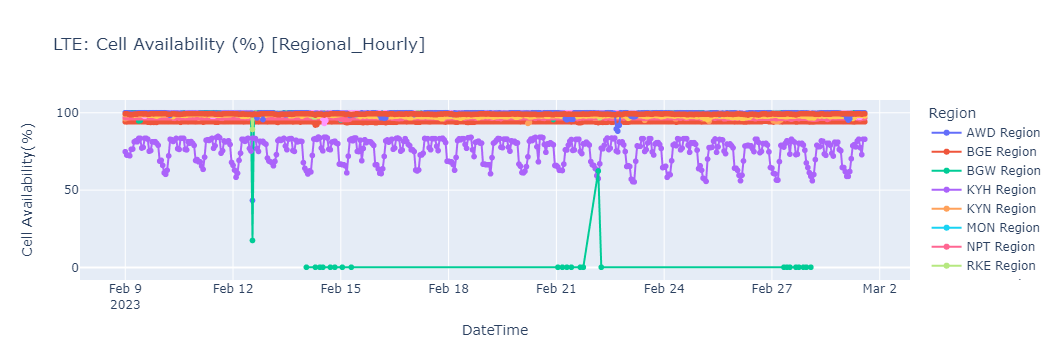

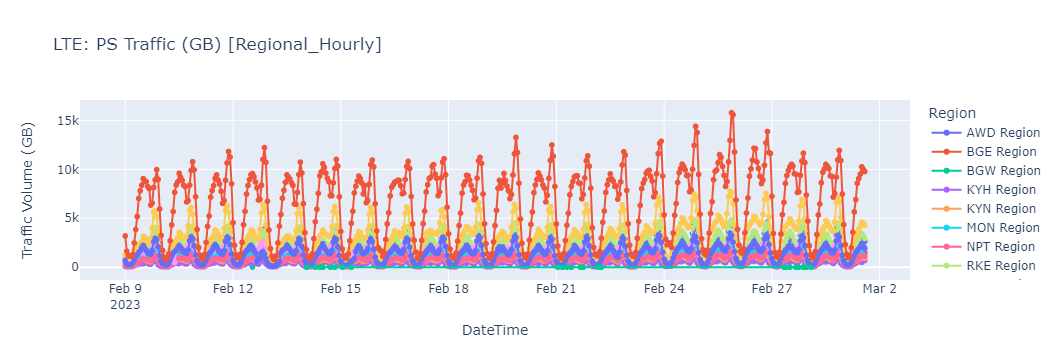

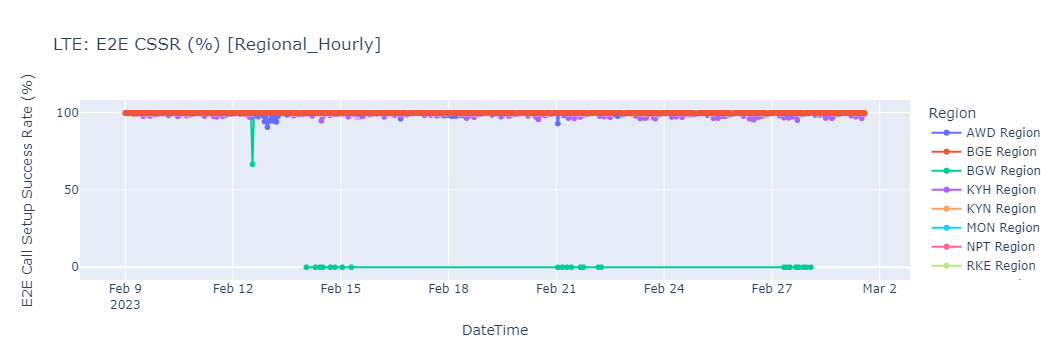

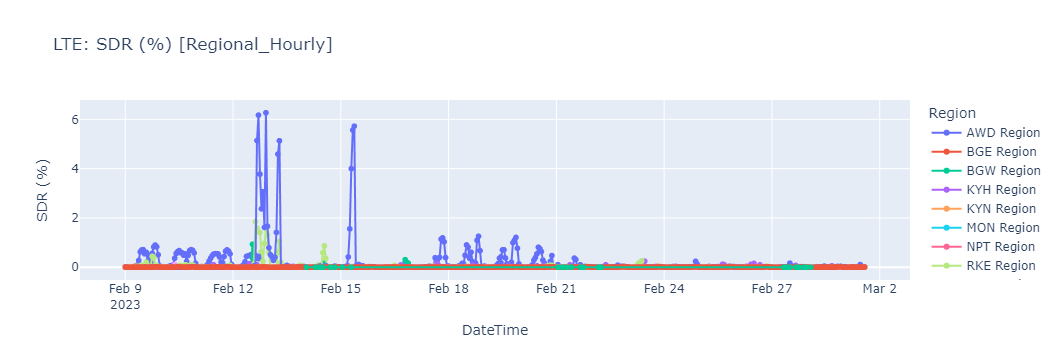

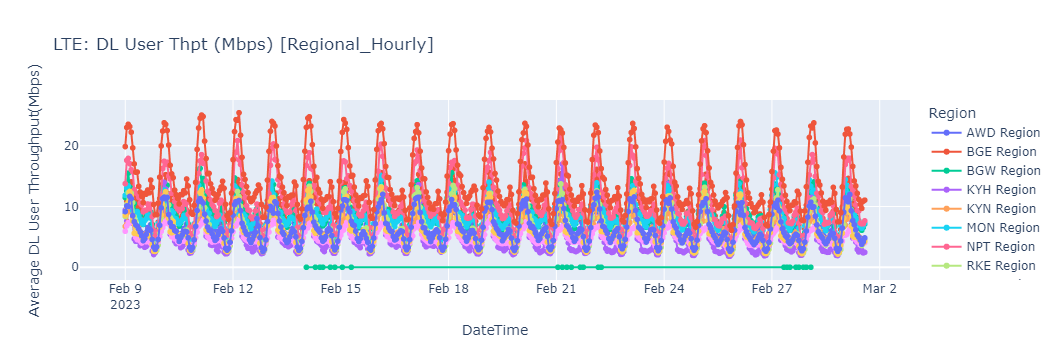

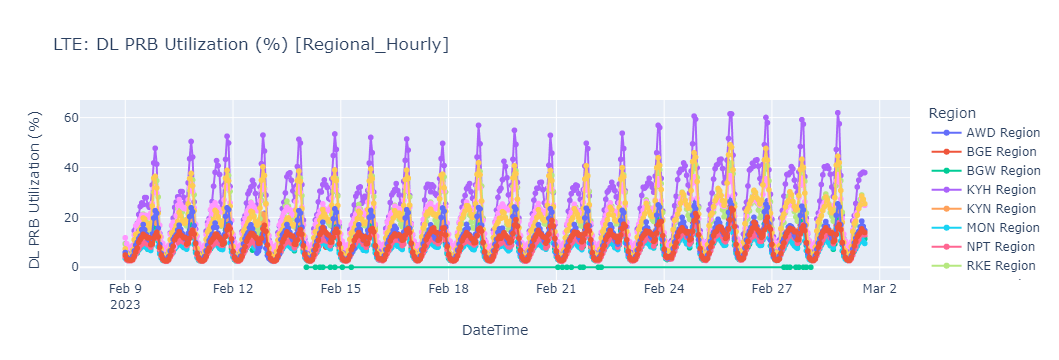

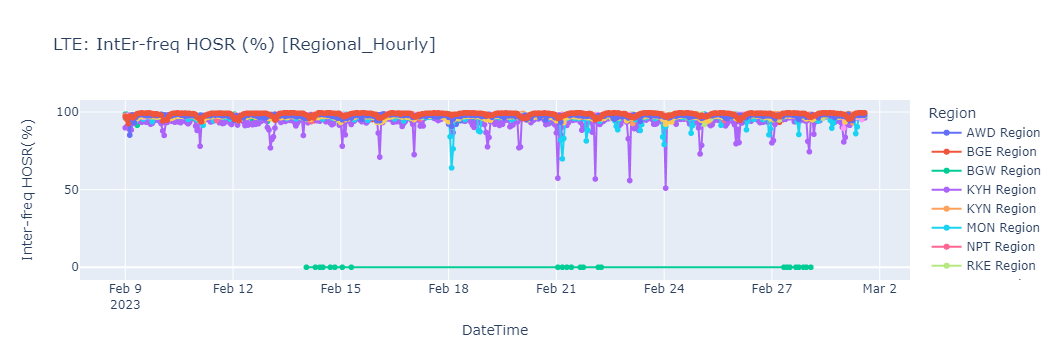

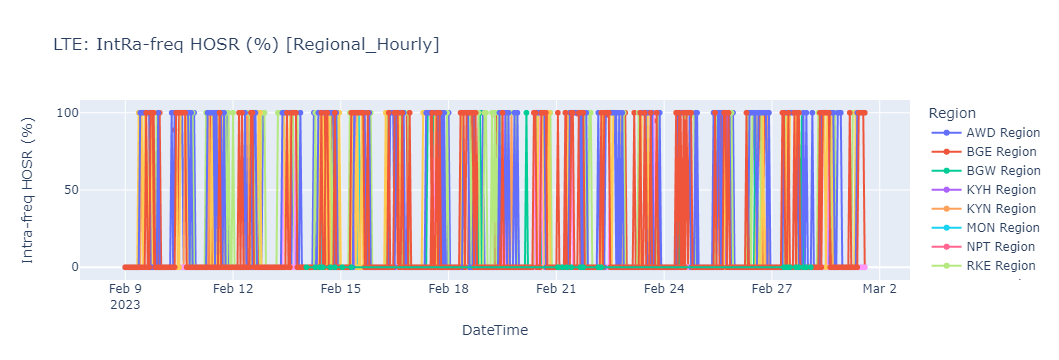

In [34]:
tech = input('G/U/L?:')
gran = input('hly/dly?:')
rptype = input('WN/RGN?:')

if (tech == 'L'):
    wnd, wnh, rgnd, rgnh = lte_gp(L)
    if (gran=='dly') and (rptype=='WN'):
            fig1 = px.line(wnd, x='Date', y='Cell Availability(%)', title='LTE: Cell Availability (%) [Whole Network_Daily]', markers=True)
            fig2 = px.line(wnd, x='Date', y='Traffic Volume (GB)', title='LTE: PS Traffic (GB) [Whole Network_Daily]', markers=True)
            fig3 = px.line(wnd, x='Date', y='E2E Call Setup Success Rate (%)', title='LTE: E2E CSSR (%) [Whole Network_Daily]', markers=True)
            fig4 = px.line(wnd, x='Date', y='SDR (%)', title='LTE: SDR (%) [Whole Network_Daily]', markers=True)
            fig5 = px.line(wnd, x='Date', y='L.UL.Interference.Avg(dBm)', title='LTE: Interference (dBm) [Whole Network_Daily]', markers=True)
            fig6 = px.line(wnd, x='Date', y='RRC Connected Users', title='LTE: RRC Connected Users [Whole Network_Daily]', markers=True)
            fig7 = px.line(wnd, x='Date', y='Average DL User Throughput(Mbps)', title='LTE: DL User Thpt (Mbps) [Whole Network_Daily]', markers=True)
            fig8 = px.line(wnd, x='Date', y='DL PRB Utilization (%)', title='LTE: DL PRB Utilization (%) [Whole Network_Daily]', markers=True)
            fig9 = px.line(wnd, x='Date', y='CSFB CSSR (%)', title='LTE: CSFB CSSR [Whole Network_Daily]', markers=True)
            fig10 = px.line(wnd, x='Date', y='Inter-freq HOSR(%)', title='LTE: IntEr-freq HOSR (%) [Whole Network_Daily]', markers=True)
            fig11 = px.line(wnd, x='Date', y='Intra-freq HOSR (%)', title='LTE: IntRa-freq HOSR (%) [Whole Network_Daily]', markers=True)
    elif (gran=='hly') and (rptype=='WN'):
            fig1 = px.line(wnh, x='DateTime', y='Cell Availability(%)', title='LTE: Cell Availability (%) [Whole Network_Hourly]', markers=True)
            fig2 = px.line(wnh, x='DateTime', y='Traffic Volume (GB)', title='LTE: PS Traffic (GB) [Whole Network_Hourly]', markers=True)
            fig3 = px.line(wnh, x='DateTime', y='E2E Call Setup Success Rate (%)', title='LTE: E2E CSSR (%) [Whole Network_Hourly]', markers=True)
            fig4 = px.line(wnh, x='DateTime', y='SDR (%)', title='LTE: SDR (%) [Whole Network_Hourly]', markers=True)
            fig5 = px.line(wnh, x='DateTime', y='L.UL.Interference.Avg(dBm)', title='LTE: Interference (dBm) [Whole Network_Hourly]', markers=True)
            fig6 = px.line(wnh, x='DateTime', y='RRC Connected Users', title='LTE: RRC Connected Users [Whole Network_Hourly]', markers=True)
            fig7 = px.line(wnh, x='DateTime', y='Average DL User Throughput(Mbps)', title='LTE: DL User Thpt (Mbps) [Whole Network_Hourly]', markers=True)
            fig8 = px.line(wnh, x='DateTime', y='DL PRB Utilization (%)', title='LTE: DL PRB Utilization (%) [Whole Network_Hourly]', markers=True)
            fig9 = px.line(wnh, x='DateTime', y='CSFB CSSR (%)', title='LTE: CSFB CSSR [Whole Network_Hourly]', markers=True)
            fig10 = px.line(wnh, x='DateTime', y='Inter-freq HOSR(%)', title='LTE: IntEr-freq HOSR (%) [Whole Network_Hourly]', markers=True)
            fig11 = px.line(wnh, x='DateTime', y='Intra-freq HOSR (%)', title='LTE: IntRa-freq HOSR (%) [Whole Network_Hourly]', markers=True)
    elif(gran=='dly') and (rptype=='RGN'):
            fig1 = px.line(rgnd, x='Date', color='Region', y='Cell Availability(%)', title='LTE: Cell Availability (%) [Regional_Daily]', markers=True)
            fig2 = px.line(rgnd, x='Date', color='Region', y='Traffic Volume (GB)', title='LTE: PS Traffic (GB) [Regional_Daily]', markers=True)
            fig3 = px.line(rgnd, x='Date', color='Region', y='E2E Call Setup Success Rate (%)', title='LTE: E2E CSSR (%) [Regional_Daily]', markers=True)
            fig4 = px.line(rgnd, x='Date', color='Region', y='SDR (%)', title='LTE: SDR (%) [Regional_Daily]', markers=True)
            fig5 = px.line(rgnd, x='Date', color='Region', y='L.UL.Interference.Avg(dBm)', title='LTE: Interference (dBm) [Regional_Daily]', markers=True)
            fig6 = px.line(rgnd, x='Date', color='Region', y='RRC Connected Users', title='LTE: RRC Connected Users [Regional_Daily]', markers=True)
            fig7 = px.line(rgnd, x='Date', color='Region', y='Average DL User Throughput(Mbps)', title='LTE: DL User Thpt (Mbps) [Regional_Daily]', markers=True)
            fig8 = px.line(rgnd, x='Date', color='Region', y='DL PRB Utilization (%)', title='LTE: DL PRB Utilization (%) [Regional_Daily]', markers=True)
            fig9 = px.line(rgnd, x='Date', color='Region', y='CSFB CSSR (%)', title='LTE: CSFB CSSR [Regional_Daily]', markers=True)
            fig10 = px.line(rgnd, x='Date', color='Region', y='Inter-freq HOSR(%)', title='LTE: IntEr-freq HOSR (%) [Regional_Daily]', markers=True)
            fig11 = px.line(rgnd, x='Date', color='Region', y='Intra-freq HOSR (%)', title='LTE: IntRa-freq HOSR (%) [Regional_Daily]', markers=True)
    elif(gran=='hly') and (rptype=='RGN'):
            fig1 = px.line(rgnh, x='DateTime', color='Region', y='Cell Availability(%)', title='LTE: Cell Availability (%) [Regional_Hourly]', markers=True)
            fig2 = px.line(rgnh, x='DateTime', color='Region', y='Traffic Volume (GB)', title='LTE: PS Traffic (GB) [Regional_Hourly]', markers=True)
            fig3 = px.line(rgnh, x='DateTime', color='Region', y='E2E Call Setup Success Rate (%)', title='LTE: E2E CSSR (%) [Regional_Hourly]', markers=True)
            fig4 = px.line(rgnh, x='DateTime', color='Region', y='SDR (%)', title='LTE: SDR (%) [Regional_Hourly]', markers=True)
            fig5 = px.line(rgnh, x='DateTime', color='Region', y='L.UL.Interference.Avg(dBm)', title='LTE: Interference (dBm) [Regional_Hourly]', markers=True)
            fig6 = px.line(rgnh, x='DateTime', color='Region', y='RRC Connected Users', title='LTE: RRC Connected Users [Regional_Hourly]', markers=True)
            fig7 = px.line(rgnh, x='DateTime', color='Region', y='Average DL User Throughput(Mbps)', title='LTE: DL User Thpt (Mbps) [Regional_Hourly]', markers=True)
            fig8 = px.line(rgnh, x='DateTime', color='Region', y='DL PRB Utilization (%)', title='LTE: DL PRB Utilization (%) [Regional_Hourly]', markers=True)
            fig9 = px.line(rgnh, x='DateTime', color='Region', y='CSFB CSSR (%)', title='LTE: CSFB CSSR [Regional_Hourly]', markers=True)
            fig10 = px.line(rgnh, x='DateTime', color='Region', y='Inter-freq HOSR(%)', title='LTE: IntEr-freq HOSR (%) [Regional_Hourly]', markers=True)
            fig11 = px.line(rgnh, x='DateTime', color='Region', y='Intra-freq HOSR (%)', title='LTE: IntRa-freq HOSR (%) [Regional_Hourly]', markers=True)
            
elif (tech == 'U'):
    wnd, wnh, rgnd, rgnh = umts_gp(U)
    if (gran=='dly') and (rptype=='WN'):
            fig1 = px.line(wnd, x='Date', y='Cell Availability(%)', title='UMTS: Cell Availability (%) [Whole Network_Daily]', markers=True)
            fig2 = px.line(wnd, x='Date', y='CS Traffic (Erl)', title='UMTS: CS Traffic (Erl) [Whole Network_Daily]', markers=True)
            fig3 = px.line(wnd, x='Date', y='PS Traffic (MB)(MB)', title='UMTS: PS Traffic (MB) [Whole Network_Daily]', markers=True)
            fig4 = px.line(wnd, x='Date', y='VS.MeanRTWP(dBm)', title='UMTS: Interference (dBm) [Whole Network_Daily]', markers=True)
            fig5 = px.line(wnd, x='Date', y='Mute Call Counts', title='UMTS: Mute Call Counts [Whole Network_Daily]', markers=True)
            fig6 = px.line(wnd, x='Date', y='M-Code Congestion(Times)', title='UMTS: Code Congestion Times [Whole Network_Daily]', markers=True)
            fig7 = px.line(wnd, x='Date', y='CS Call Setup Success Rate (%)', title='UMTS: CS CSSR (%) [Whole Network_Daily]', markers=True)
            fig8 = px.line(wnd, x='Date', y='PS Call Setup Success Rate (%)', title='UMTS: PS CSSR (%) [Whole Network_Daily]', markers=True)
            fig9 = px.line(wnd, x='Date', y='CS DCR (%)(%)', title='UMTS: CS CDR (%) [Whole Network_Daily]', markers=True)
            fig10 = px.line(wnd, x='Date', y='PS DCR (%)(%)', title='UMTS: PS CDR (%) [Whole Network_Daily]', markers=True)
            fig11 = px.line(wnd, x='Date', y='RAB DLPower Congestion', title='UMTS: DL Pwr Congestion [Whole Network_Daily]', markers=True)
    elif (gran=='hly') and (rptype=='WN'):
            fig1 = px.line(wnh, x='DateTime', y='Cell Availability(%)', title='UMTS: Cell Availability (%) [Whole Network_Hourly]', markers=True)
            fig2 = px.line(wnh, x='DateTime', y='CS Traffic (Erl)', title='UMTS: CS Traffic (Erl) [Whole Network_Hourly]', markers=True)
            fig3 = px.line(wnh, x='DateTime', y='PS Traffic (MB)(MB)', title='UMTS: PS Traffic (MB) [Whole Network_Hourly]', markers=True)
            fig4 = px.line(wnh, x='DateTime', y='VS.MeanRTWP(dBm)', title='UMTS: Interference (dBm) [Whole Network_Hourly]', markers=True)
            fig5 = px.line(wnh, x='DateTime', y='Mute Call Counts', title='UMTS: Mute Call Counts [Whole Network_Hourly]', markers=True)
            fig6 = px.line(wnh, x='DateTime', y='M-Code Congestion(Times)', title='UMTS: Code Congestion Times [Whole Network_Hourly]', markers=True)
            fig7 = px.line(wnh, x='DateTime', y='CS Call Setup Success Rate (%)', title='UMTS: CS CSSR (%) [Whole Network_Hourly]', markers=True)
            fig8 = px.line(wnh, x='DateTime', y='PS Call Setup Success Rate (%)', title='UMTS: PS CSSR (%) [Whole Network_Hourly]', markers=True)
            fig9 = px.line(wnh, x='DateTime', y='CS DCR (%)(%)', title='UMTS: CS CDR (%) [Whole Network_Hourly]', markers=True)
            fig10 = px.line(wnh, x='DateTime', y='PS DCR (%)(%)', title='UMTS: PS CDR (%) [Whole Network_Hourly]', markers=True)
            fig11 = px.line(wnh, x='DateTime', y='RAB DLPower Congestion', title='UMTS: DL Pwr Congestion [Whole Network_Hourly]', markers=True)
    elif (gran=='dly') and (rptype=='RGN'):
            fig1 = px.line(rgnd, x='Date', color='Region', y='Cell Availability(%)', title='UMTS: Cell Availability (%) [Regional_Daily]', markers=True)
            fig2 = px.line(rgnd, x='Date', color='Region', y='CS Traffic (Erl)', title='UMTS: CS Traffic (Erl) [Regional_Daily]', markers=True)
            fig3 = px.line(rgnd, x='Date', color='Region', y='PS Traffic (MB)(MB)', title='UMTS: PS Traffic (MB) [Regional_Daily]', markers=True)
            fig4 = px.line(rgnd, x='Date', color='Region', y='VS.MeanRTWP(dBm)', title='UMTS: Interference (dBm) [Regional_Daily]', markers=True)
            fig5 = px.line(rgnd, x='Date', color='Region', y='Mute Call Counts', title='UMTS: Mute Call Counts [Regional_Daily]', markers=True)
            fig6 = px.line(rgnd, x='Date', color='Region', y='M-Code Congestion(Times)', title='UMTS: Code Congestion Times [Regional_Daily]', markers=True)
            fig7 = px.line(rgnd, x='Date', color='Region', y='CS Call Setup Success Rate (%)', title='UMTS: CS CSSR (%) [Regional_Daily]', markers=True)
            fig8 = px.line(rgnd, x='Date', color='Region', y='PS Call Setup Success Rate (%)', title='UMTS: PS CSSR (%) [Regional_Daily]', markers=True)
            fig9 = px.line(rgnd, x='Date', color='Region', y='CS DCR (%)(%)', title='UMTS: CS CDR (%) [Regional_Daily]', markers=True)
            fig10 = px.line(rgnd, x='Date', color='Region', y='PS DCR (%)(%)', title='UMTS: PS CDR (%) [Regional_Daily]', markers=True)
            fig11 = px.line(rgnd, x='Date', color='Region', y='RAB DLPower Congestion', title='UMTS: DL Pwr Congestion [Regional_Daily]', markers=True)
    elif (gran=='hly') and (rptype=='RGN'):
            fig1 = px.line(rgnh, x='DateTime', color='Region', y='Cell Availability(%)', title='UMTS: Cell Availability (%) [Regional_Hourly]', markers=True)
            fig2 = px.line(rgnh, x='DateTime', color='Region', y='CS Traffic (Erl)', title='UMTS: CS Traffic (Erl) [Regional_Hourly]', markers=True)
            fig3 = px.line(rgnh, x='DateTime', color='Region', y='PS Traffic (MB)(MB)', title='UMTS: PS Traffic (MB) [Regional_Hourly]', markers=True)
            fig4 = px.line(rgnh, x='DateTime', color='Region', y='VS.MeanRTWP(dBm)', title='UMTS: Interference (dBm) [Regional_Hourly]', markers=True)
            fig5 = px.line(rgnh, x='DateTime', color='Region', y='Mute Call Counts', title='UMTS: Mute Call Counts [Regional_Hourly]', markers=True)
            fig6 = px.line(rgnh, x='DateTime', color='Region', y='M-Code Congestion(Times)', title='UMTS: Code Congestion Times [Regional_Hourly]', markers=True)
            fig7 = px.line(rgnh, x='DateTime', color='Region', y='CS Call Setup Success Rate (%)', title='UMTS: CS CSSR (%) [Regional_Hourly]', markers=True)
            fig8 = px.line(rgnh, x='DateTime', color='Region', y='PS Call Setup Success Rate (%)', title='UMTS: PS CSSR (%) [Regional_Hourly]', markers=True)
            fig9 = px.line(rgnh, x='DateTime', color='Region', y='CS DCR (%)(%)', title='UMTS: CS CDR (%) [Regional_Hourly]', markers=True)
            fig10 = px.line(rgnh, x='DateTime', color='Region', y='PS DCR (%)(%)', title='UMTS: PS CDR (%) [Regional_Hourly]', markers=True)
            fig11 = px.line(rgnh, x='DateTime', color='Region', y='RAB DLPower Congestion', title='UMTS: DL Pwr Congestion [Regional_Hourly]', markers=True)               
    
else:
    wnd, wnh, rgnd, rgnh = gsm_gp(G)
    if (gran=='dly') and (rptype=='WN'):
            fig1 = px.line(wnd, x='Date', y='TR373:Cell Availability(%)', title='GSM: Cell Availability (%) [Whole Network_Daily]', markers=True)
            fig2 = px.line(wnd, x='Date', y='CS Traffic (Erl)', title='GSM: CS Traffic (Erl) [Whole Network_Daily]', markers=True)
            fig3 = px.line(wnd, x='Date', y='PS Traffic (MB)', title='GSM: PS Traffic (MB) [Whole Network_Daily]', markers=True)
            fig4 = px.line(wnd, x='Date', y='Interference Band[4-5]%', title='GSM: Interference (%) [Whole Network_Daily]', markers=True)
            fig5 = px.line(wnd, x='Date', y='Mute Call Counts', title='GSM: Mute Call Counts [Whole Network_Daily]', markers=True)
            fig6 = px.line(wnd, x='Date', y='CS SSR (%)', title='GSM: CS CSSR (%) [Whole Network_Daily]', markers=True)
            fig7 = px.line(wnd, x='Date', y='PS CSSR (%)(%)', title='GSM: PS CSSR (%) [Whole Network_Daily]', markers=True)
            fig8 = px.line(wnd, x='Date', y='GSM Utilization(%)', title='GSM: Utilization (%) [Whole Network_Daily]', markers=True)
            fig9 = px.line(wnd, x='Date', y='VAMOS Traffic(Erl)', title='GSM: VAMOS Traffic (Erl) [Whole Network_Daily]', markers=True)
            fig10 = px.line(wnd, x='Date', y='GSM TCH Congestion Rate(%)', title='GSM: TCH Cong Rate (%) [Whole Network_Daily]', markers=True)
            fig11 = px.line(wnd, x='Date', y='SDCCH Cong Rate (%)(%)', title='GSM: SDCCH Congestion Rate (%) [Whole Network_Daily]', markers=True)
    elif (gran=='hly') and (rptype=='WN'):
            fig1 = px.line(wnh, x='DateTime', y='TR373:Cell Availability(%)', title='GSM: Cell Availability (%) [Whole Network_Hourly]', markers=True)
            fig2 = px.line(wnh, x='DateTime', y='CS Traffic (Erl)', title='GSM: CS Traffic (Erl) [Whole Network_Hourly]', markers=True)
            fig3 = px.line(wnh, x='DateTime', y='PS Traffic (MB)', title='GSM: PS Traffic (MB) [Whole Network_Hourly]', markers=True)
            fig4 = px.line(wnh, x='DateTime', y='Interference Band[4-5]%', title='GSM: Interference (%) [Whole Network_Hourly]', markers=True)
            fig5 = px.line(wnh, x='DateTime', y='Mute Call Counts', title='GSM: Mute Call Counts [Whole Network_Hourly]', markers=True)
            fig6 = px.line(wnh, x='DateTime', y='CS SSR (%)', title='GSM: CS CSSR (%) [Whole Network_Hourly]', markers=True)
            fig7 = px.line(wnh, x='DateTime', y='PS CSSR (%)(%)', title='GSM: PS CSSR (%) [Whole Network_Hourly]', markers=True)
            fig8 = px.line(wnh, x='DateTime', y='GSM Utilization(%)', title='GSM: Utilization (%) [Whole Network_Hourly]', markers=True)
            fig9 = px.line(wnh, x='DateTime', y='VAMOS Traffic(Erl)', title='GSM: VAMOS Traffic (Erl) [Whole Network_Hourly]', markers=True)
            fig10 = px.line(wnh, x='DateTime', y='GSM TCH Congestion Rate(%)', title='GSM: TCH Cong Rate (%) [Whole Network_Hourly]', markers=True)
            fig11 = px.line(wnh, x='DateTime', y='SDCCH Cong Rate (%)(%)', title='GSM: SDCCH Congestion Rate (%) [Whole Network_Hourly]', markers=True)
    elif (gran=='dly') and (rptype=='RGN'):
            fig1 = px.line(rgnd, x='Date', color='Region', y='TR373:Cell Availability(%)', title='GSM: Cell Availability (%) [Regional_Daily]', markers=True)
            fig2 = px.line(rgnd, x='Date', color='Region', y='CS Traffic (Erl)', title='GSM: CS Traffic (Erl) [Regional_Daily]', markers=True)
            fig3 = px.line(rgnd, x='Date', color='Region', y='PS Traffic (MB)', title='GSM: PS Traffic (MB) [Regional_Daily]', markers=True)
            fig4 = px.line(rgnd, x='Date', color='Region', y='Interference Band[4-5]%', title='GSM: Interference (%) [Regional_Daily]', markers=True)
            fig5 = px.line(rgnd, x='Date', color='Region', y='Mute Call Counts', title='GSM: Mute Call Counts [Regional_Daily]', markers=True)
            fig6 = px.line(rgnd, x='Date', color='Region', y='CS SSR (%)', title='GSM: CS CSSR (%) [Regional_Daily]', markers=True)
            fig7 = px.line(rgnd, x='Date', color='Region', y='PS CSSR (%)(%)', title='GSM: PS CSSR (%) [Regional_Daily]', markers=True)
            fig8 = px.line(rgnd, x='Date', color='Region', y='GSM Utilization(%)', title='GSM: Utilization (%) [Regional_Daily]', markers=True)
            fig9 = px.line(rgnd, x='Date', color='Region', y='VAMOS Traffic(Erl)', title='GSM: VAMOS Traffic (Erl) [Regional_Daily]', markers=True)
            fig10 = px.line(rgnd, x='Date', color='Region', y='GSM TCH Congestion Rate(%)', title='GSM: TCH Cong Rate (%) [Regional_Daily]', markers=True)
            fig11 = px.line(rgnd, x='Date', color='Region', y='SDCCH Cong Rate (%)(%)', title='GSM: SDCCH Congestion Rate (%) [Regional_Daily]', markers=True)
    elif (gran=='hly') and (rptype=='RGN'):
            fig1 = px.line(rgnh, x='DateTime', color='Region', y='TR373:Cell Availability(%)', title='GSM: Cell Availability (%) [Regional_Hourly]', markers=True)
            fig2 = px.line(rgnh, x='DateTime', color='Region', y='CS Traffic (Erl)', title='GSM: CS Traffic (Erl) [Regional_Hourly]', markers=True)
            fig3 = px.line(rgnh, x='DateTime', color='Region', y='PS Traffic (MB)', title='GSM: PS Traffic (MB) [Regional_Hourly]', markers=True)
            fig4 = px.line(rgnh, x='DateTime', color='Region', y='Interference Band[4-5]%', title='GSM: Interference (%) [Regional_Hourly]', markers=True)
            fig5 = px.line(rgnh, x='DateTime', color='Region', y='Mute Call Counts', title='GSM: Mute Call Counts [Regional_Hourly]', markers=True)
            fig6 = px.line(rgnh, x='DateTime', color='Region', y='CS SSR (%)', title='GSM: CS CSSR (%) [Regional_Hourly]', markers=True)
            fig7 = px.line(rgnh, x='DateTime', color='Region', y='PS CSSR (%)(%)', title='GSM: PS CSSR (%) [Regional_Hourly]', markers=True)
            fig8 = px.line(rgnh, x='DateTime', color='Region', y='GSM Utilization(%)', title='GSM: Utilization (%) [Regional_Hourly]', markers=True)
            fig9 = px.line(rgnh, x='DateTime', color='Region', y='VAMOS Traffic(Erl)', title='GSM: VAMOS Traffic (Erl) [Regional_Hourly]', markers=True)
            fig10 = px.line(rgnh, x='DateTime', color='Region', y='GSM TCH Congestion Rate(%)', title='GSM: TCH Cong Rate (%) [Regional_Hourly]', markers=True)
            fig11 = px.line(rgnh, x='DateTime', color='Region', y='SDCCH Cong Rate (%)(%)', title='GSM: SDCCH Congestion Rate (%) [Regional_Hourly]', markers=True)   
fig1.show()
fig2.show()
fig3.show()
fig4.show()
fig5.show()
fig6.show()
fig7.show()
fig8.show()
fig9.show()
fig10.show()
fig11.show()

In [37]:
@app.callback([Output(component_id='plot-1', component_property='children'), Output(component_id='plot-2', component_property='children'),
               Output(component_id='plot-3', component_property='children'), Output(component_id='plot-4', component_property='children'),
               Output(component_id='plot-5', component_property='children'), Output(component_id='plot-6', component_property='children'),
               Output(component_id='plot-7', component_property='children'), Output(component_id='plot-8', component_property='children'),
               Output(component_id='plot-9', component_property='children'), Output(component_id='plot-10', component_property='children'),
               Output(component_id='plot-11', component_property='children')],
              [Input(component_id='technology', component_property='value'), Input(component_id='granularity', component_property='value'),
               Input(component_id='report-type', component_property='value')],
              [State('plot-1', 'children'), State('plot-2', 'children'), State('plot-3', 'children'), State('plot-4', 'children'),
               State('plot-5', 'children'), State('plot-6', 'children'), State('plot-7', 'children'), State('plot-8', 'children'),
               State('plot-9', 'children'), State('plot-10', 'children'), State('plot-11', 'children')])

def get_graph_data(tech, gran, rptype, p1, p2, p3, p4, p5, p6, p7, p8, p9, p10, p11):
    if (tech == 'L'):
        wnd, wnh, rgnd, rgnh = lte_gp(L)
        if (gran=='dly') and (rptype=='WN'):
            fig1 = px.line(wnd, x='Date', y='Cell Availability(%)', title='LTE: Cell Availability (%) [Whole Network_Daily]', markers=True)
            fig2 = px.line(wnd, x='Date', y='Traffic Volume (GB)', title='LTE: PS Traffic (GB) [Whole Network_Daily]', markers=True)
            fig3 = px.line(wnd, x='Date', y='E2E Call Setup Success Rate (%)', title='LTE: E2E CSSR (%) [Whole Network_Daily]', markers=True)
            fig4 = px.line(wnd, x='Date', y='SDR (%)', title='LTE: SDR (%) [Whole Network_Daily]', markers=True)
            fig5 = px.line(wnd, x='Date', y='L.UL.Interference.Avg(dBm)', title='LTE: Interference (dBm) [Whole Network_Daily]', markers=True)
            fig6 = px.line(wnd, x='Date', y='RRC Connected Users', title='LTE: RRC Connected Users [Whole Network_Daily]', markers=True)
            fig7 = px.line(wnd, x='Date', y='Average DL User Throughput(Mbps)', title='LTE: DL User Thpt (Mbps) [Whole Network_Daily]', markers=True)
            fig8 = px.line(wnd, x='Date', y='DL PRB Utilization (%)', title='LTE: DL PRB Utilization (%) [Whole Network_Daily]', markers=True)
            fig9 = px.line(wnd, x='Date', y='CSFB CSSR (%)', title='LTE: CSFB CSSR [Whole Network_Daily]', markers=True)
            fig10 = px.line(wnd, x='Date', y='Inter-freq HOSR(%)', title='LTE: IntEr-freq HOSR (%) [Whole Network_Daily]', markers=True)
            fig11 = px.line(wnd, x='Date', y='Intra-freq HOSR (%)', title='LTE: IntRa-freq HOSR (%) [Whole Network_Daily]', markers=True)
        elif (gran=='hly') and (rptype=='WN'):
            fig1 = px.line(wnh, x='DateTime', y='Cell Availability(%)', title='LTE: Cell Availability (%) [Whole Network_Hourly]', markers=True)
            fig2 = px.line(wnh, x='DateTime', y='Traffic Volume (GB)', title='LTE: PS Traffic (GB) [Whole Network_Hourly]', markers=True)
            fig3 = px.line(wnh, x='DateTime', y='E2E Call Setup Success Rate (%)', title='LTE: E2E CSSR (%) [Whole Network_Hourly]', markers=True)
            fig4 = px.line(wnh, x='DateTime', y='SDR (%)', title='LTE: SDR (%) [Whole Network_Hourly]', markers=True)
            fig5 = px.line(wnh, x='DateTime', y='L.UL.Interference.Avg(dBm)', title='LTE: Interference (dBm) [Whole Network_Hourly]', markers=True)
            fig6 = px.line(wnh, x='DateTime', y='RRC Connected Users', title='LTE: RRC Connected Users [Whole Network_Hourly]', markers=True)
            fig7 = px.line(wnh, x='DateTime', y='Average DL User Throughput(Mbps)', title='LTE: DL User Thpt (Mbps) [Whole Network_Hourly]', markers=True)
            fig8 = px.line(wnh, x='DateTime', y='DL PRB Utilization (%)', title='LTE: DL PRB Utilization (%) [Whole Network_Hourly]', markers=True)
            fig9 = px.line(wnh, x='DateTime', y='CSFB CSSR (%)', title='LTE: CSFB CSSR [Whole Network_Hourly]', markers=True)
            fig10 = px.line(wnh, x='DateTime', y='Inter-freq HOSR(%)', title='LTE: IntEr-freq HOSR (%) [Whole Network_Hourly]', markers=True)
            fig11 = px.line(wnh, x='DateTime', y='Intra-freq HOSR (%)', title='LTE: IntRa-freq HOSR (%) [Whole Network_Hourly]', markers=True)
        elif(gran=='dly') and (rptype=='RGN'):
            fig1 = px.line(rgnd, x='Date', color='Region', y='Cell Availability(%)', title='LTE: Cell Availability (%) [Regional_Daily]', markers=True)
            fig2 = px.line(rgnd, x='Date', color='Region', y='Traffic Volume (GB)', title='LTE: PS Traffic (GB) [Regional_Daily]', markers=True)
            fig3 = px.line(rgnd, x='Date', color='Region', y='E2E Call Setup Success Rate (%)', title='LTE: E2E CSSR (%) [Regional_Daily]', markers=True)
            fig4 = px.line(rgnd, x='Date', color='Region', y='SDR (%)', title='LTE: SDR (%) [Regional_Daily]', markers=True)
            fig5 = px.line(rgnd, x='Date', color='Region', y='L.UL.Interference.Avg(dBm)', title='LTE: Interference (dBm) [Regional_Daily]', markers=True)
            fig6 = px.line(rgnd, x='Date', color='Region', y='RRC Connected Users', title='LTE: RRC Connected Users [Regional_Daily]', markers=True)
            fig7 = px.line(rgnd, x='Date', color='Region', y='Average DL User Throughput(Mbps)', title='LTE: DL User Thpt (Mbps) [Regional_Daily]', markers=True)
            fig8 = px.line(rgnd, x='Date', color='Region', y='DL PRB Utilization (%)', title='LTE: DL PRB Utilization (%) [Regional_Daily]', markers=True)
            fig9 = px.line(rgnd, x='Date', color='Region', y='CSFB CSSR (%)', title='LTE: CSFB CSSR [Regional_Daily]', markers=True)
            fig10 = px.line(rgnd, x='Date', color='Region', y='Inter-freq HOSR(%)', title='LTE: IntEr-freq HOSR (%) [Regional_Daily]', markers=True)
            fig11 = px.line(rgnd, x='Date', color='Region', y='Intra-freq HOSR (%)', title='LTE: IntRa-freq HOSR (%) [Regional_Daily]', markers=True)
        elif(gran=='hly') and (rptype=='RGN'):
            fig1 = px.line(rgnh, x='DateTime', color='Region', y='Cell Availability(%)', title='LTE: Cell Availability (%) [Regional_Hourly]', markers=True)
            fig2 = px.line(rgnh, x='DateTime', color='Region', y='Traffic Volume (GB)', title='LTE: PS Traffic (GB) [Regional_Hourly]', markers=True)
            fig3 = px.line(rgnh, x='DateTime', color='Region', y='E2E Call Setup Success Rate (%)', title='LTE: E2E CSSR (%) [Regional_Hourly]', markers=True)
            fig4 = px.line(rgnh, x='DateTime', color='Region', y='SDR (%)', title='LTE: SDR (%) [Regional_Hourly]', markers=True)
            fig5 = px.line(rgnh, x='DateTime', color='Region', y='L.UL.Interference.Avg(dBm)', title='LTE: Interference (dBm) [Regional_Hourly]', markers=True)
            fig6 = px.line(rgnh, x='DateTime', color='Region', y='RRC Connected Users', title='LTE: RRC Connected Users [Regional_Hourly]', markers=True)
            fig7 = px.line(rgnh, x='DateTime', color='Region', y='Average DL User Throughput(Mbps)', title='LTE: DL User Thpt (Mbps) [Regional_Hourly]', markers=True)
            fig8 = px.line(rgnh, x='DateTime', color='Region', y='DL PRB Utilization (%)', title='LTE: DL PRB Utilization (%) [Regional_Hourly]', markers=True)
            fig9 = px.line(rgnh, x='DateTime', color='Region', y='CSFB CSSR (%)', title='LTE: CSFB CSSR [Regional_Hourly]', markers=True)
            fig10 = px.line(rgnh, x='DateTime', color='Region', y='Inter-freq HOSR(%)', title='LTE: IntEr-freq HOSR (%) [Regional_Hourly]', markers=True)
            fig11 = px.line(rgnh, x='DateTime', color='Region', y='Intra-freq HOSR (%)', title='LTE: IntRa-freq HOSR (%) [Regional_Hourly]', markers=True)
            
    elif (tech == 'U'):
        wnd, wnh, rgnd, rgnh = umts_gp(U)
        if (gran=='dly') and (rptype=='WN'):
            fig1 = px.line(wnd, x='Date', y='Cell Availability(%)', title='UMTS: Cell Availability (%) [Whole Network_Daily]', markers=True)
            fig2 = px.line(wnd, x='Date', y='CS Traffic (Erl)', title='UMTS: CS Traffic (Erl) [Whole Network_Daily]', markers=True)
            fig3 = px.line(wnd, x='Date', y='PS Traffic (MB)(MB)', title='UMTS: PS Traffic (MB) [Whole Network_Daily]', markers=True)
            fig4 = px.line(wnd, x='Date', y='VS.MeanRTWP(dBm)', title='UMTS: Interference (dBm) [Whole Network_Daily]', markers=True)
            fig5 = px.line(wnd, x='Date', y='Mute Call Counts', title='UMTS: Mute Call Counts [Whole Network_Daily]', markers=True)
            fig6 = px.line(wnd, x='Date', y='M-Code Congestion(Times)', title='UMTS: Code Congestion Times [Whole Network_Daily]', markers=True)
            fig7 = px.line(wnd, x='Date', y='CS Call Setup Success Rate (%)', title='UMTS: CS CSSR (%) [Whole Network_Daily]', markers=True)
            fig8 = px.line(wnd, x='Date', y='PS Call Setup Success Rate (%)', title='UMTS: PS CSSR (%) [Whole Network_Daily]', markers=True)
            fig9 = px.line(wnd, x='Date', y='CS DCR (%)(%)', title='UMTS: CS CDR (%) [Whole Network_Daily]', markers=True)
            fig10 = px.line(wnd, x='Date', y='PS DCR (%)(%)', title='UMTS: PS CDR (%) [Whole Network_Daily]', markers=True)
            fig11 = px.line(wnd, x='Date', y='RAB DLPower Congestion', title='UMTS: DL Pwr Congestion [Whole Network_Daily]', markers=True)
        elif (gran=='hly') and (rptype=='WN'):
            fig1 = px.line(wnh, x='DateTime', y='Cell Availability(%)', title='UMTS: Cell Availability (%) [Whole Network_Hourly]', markers=True)
            fig2 = px.line(wnh, x='DateTime', y='CS Traffic (Erl)', title='UMTS: CS Traffic (Erl) [Whole Network_Hourly]', markers=True)
            fig3 = px.line(wnh, x='DateTime', y='PS Traffic (MB)(MB)', title='UMTS: PS Traffic (MB) [Whole Network_Hourly]', markers=True)
            fig4 = px.line(wnh, x='DateTime', y='VS.MeanRTWP(dBm)', title='UMTS: Interference (dBm) [Whole Network_Hourly]', markers=True)
            fig5 = px.line(wnh, x='DateTime', y='Mute Call Counts', title='UMTS: Mute Call Counts [Whole Network_Hourly]', markers=True)
            fig6 = px.line(wnh, x='DateTime', y='M-Code Congestion(Times)', title='UMTS: Code Congestion Times [Whole Network_Hourly]', markers=True)
            fig7 = px.line(wnh, x='DateTime', y='CS Call Setup Success Rate (%)', title='UMTS: CS CSSR (%) [Whole Network_Hourly]', markers=True)
            fig8 = px.line(wnh, x='DateTime', y='PS Call Setup Success Rate (%)', title='UMTS: PS CSSR (%) [Whole Network_Hourly]', markers=True)
            fig9 = px.line(wnh, x='DateTime', y='CS DCR (%)(%)', title='UMTS: CS CDR (%) [Whole Network_Hourly]', markers=True)
            fig10 = px.line(wnh, x='DateTime', y='PS DCR (%)(%)', title='UMTS: PS CDR (%) [Whole Network_Hourly]', markers=True)
            fig11 = px.line(wnh, x='DateTime', y='RAB DLPower Congestion', title='UMTS: DL Pwr Congestion [Whole Network_Hourly]', markers=True)
        elif (gran=='dly') and (rptype=='RGN'):
            fig1 = px.line(rgnd, x='Date', color='Region', y='Cell Availability(%)', title='UMTS: Cell Availability (%) [Regional_Daily]', markers=True)
            fig2 = px.line(rgnd, x='Date', color='Region', y='CS Traffic (Erl)', title='UMTS: CS Traffic (Erl) [Regional_Daily]', markers=True)
            fig3 = px.line(rgnd, x='Date', color='Region', y='PS Traffic (MB)(MB)', title='UMTS: PS Traffic (MB) [Regional_Daily]', markers=True)
            fig4 = px.line(rgnd, x='Date', color='Region', y='VS.MeanRTWP(dBm)', title='UMTS: Interference (dBm) [Regional_Daily]', markers=True)
            fig5 = px.line(rgnd, x='Date', color='Region', y='Mute Call Counts', title='UMTS: Mute Call Counts [Regional_Daily]', markers=True)
            fig6 = px.line(rgnd, x='Date', color='Region', y='M-Code Congestion(Times)', title='UMTS: Code Congestion Times [Regional_Daily]', markers=True)
            fig7 = px.line(rgnd, x='Date', color='Region', y='CS Call Setup Success Rate (%)', title='UMTS: CS CSSR (%) [Regional_Daily]', markers=True)
            fig8 = px.line(rgnd, x='Date', color='Region', y='PS Call Setup Success Rate (%)', title='UMTS: PS CSSR (%) [Regional_Daily]', markers=True)
            fig9 = px.line(rgnd, x='Date', color='Region', y='CS DCR (%)(%)', title='UMTS: CS CDR (%) [Regional_Daily]', markers=True)
            fig10 = px.line(rgnd, x='Date', color='Region', y='PS DCR (%)(%)', title='UMTS: PS CDR (%) [Regional_Daily]', markers=True)
            fig11 = px.line(rgnd, x='Date', color='Region', y='RAB DLPower Congestion', title='UMTS: DL Pwr Congestion [Regional_Daily]', markers=True)
        elif (gran=='hly') and (rptype=='RGN'):
            fig1 = px.line(rgnh, x='DateTime', color='Region', y='Cell Availability(%)', title='UMTS: Cell Availability (%) [Regional_Hourly]', markers=True)
            fig2 = px.line(rgnh, x='DateTime', color='Region', y='CS Traffic (Erl)', title='UMTS: CS Traffic (Erl) [Regional_Hourly]', markers=True)
            fig3 = px.line(rgnh, x='DateTime', color='Region', y='PS Traffic (MB)(MB)', title='UMTS: PS Traffic (MB) [Regional_Hourly]', markers=True)
            fig4 = px.line(rgnh, x='DateTime', color='Region', y='VS.MeanRTWP(dBm)', title='UMTS: Interference (dBm) [Regional_Hourly]', markers=True)
            fig5 = px.line(rgnh, x='DateTime', color='Region', y='Mute Call Counts', title='UMTS: Mute Call Counts [Regional_Hourly]', markers=True)
            fig6 = px.line(rgnh, x='DateTime', color='Region', y='M-Code Congestion(Times)', title='UMTS: Code Congestion Times [Regional_Hourly]', markers=True)
            fig7 = px.line(rgnh, x='DateTime', color='Region', y='CS Call Setup Success Rate (%)', title='UMTS: CS CSSR (%) [Regional_Hourly]', markers=True)
            fig8 = px.line(rgnh, x='DateTime', color='Region', y='PS Call Setup Success Rate (%)', title='UMTS: PS CSSR (%) [Regional_Hourly]', markers=True)
            fig9 = px.line(rgnh, x='DateTime', color='Region', y='CS DCR (%)(%)', title='UMTS: CS CDR (%) [Regional_Hourly]', markers=True)
            fig10 = px.line(rgnh, x='DateTime', color='Region', y='PS DCR (%)(%)', title='UMTS: PS CDR (%) [Regional_Hourly]', markers=True)
            fig11 = px.line(rgnh, x='DateTime', color='Region', y='RAB DLPower Congestion', title='UMTS: DL Pwr Congestion [Regional_Hourly]', markers=True)               
    
    else:
        wnd, wnh, rgnd, rgnh = gsm_gp(G)
        if (gran=='dly') and (rptype=='WN'):
            fig1 = px.line(wnd, x='Date', y='TR373:Cell Availability(%)', title='GSM: Cell Availability (%) [Whole Network_Daily]', markers=True)
            fig2 = px.line(wnd, x='Date', y='CS Traffic (Erl)', title='GSM: CS Traffic (Erl) [Whole Network_Daily]', markers=True)
            fig3 = px.line(wnd, x='Date', y='PS Traffic (MB)', title='GSM: PS Traffic (MB) [Whole Network_Daily]', markers=True)
            fig4 = px.line(wnd, x='Date', y='Interference Band[4-5]%', title='GSM: Interference (%) [Whole Network_Daily]', markers=True)
            fig5 = px.line(wnd, x='Date', y='Mute Call Counts', title='GSM: Mute Call Counts [Whole Network_Daily]', markers=True)
            fig6 = px.line(wnd, x='Date', y='CS SSR (%)', title='GSM: CS CSSR (%) [Whole Network_Daily]', markers=True)
            fig7 = px.line(wnd, x='Date', y='PS CSSR (%)(%)', title='GSM: PS CSSR (%) [Whole Network_Daily]', markers=True)
            fig8 = px.line(wnd, x='Date', y='GSM Utilization(%)', title='GSM: Utilization (%) [Whole Network_Daily]', markers=True)
            fig9 = px.line(wnd, x='Date', y='VAMOS Traffic(Erl)', title='GSM: VAMOS Traffic (Erl) [Whole Network_Daily]', markers=True)
            fig10 = px.line(wnd, x='Date', y='GSM TCH Congestion Rate(%)', title='GSM: TCH Cong Rate (%) [Whole Network_Daily]', markers=True)
            fig11 = px.line(wnd, x='Date', y='SDCCH Cong Rate (%)(%)', title='GSM: SDCCH Congestion Rate (%) [Whole Network_Daily]', markers=True)
        elif (gran=='hly') and (rptype=='WN'):
            fig1 = px.line(wnh, x='DateTime', y='TR373:Cell Availability(%)', title='GSM: Cell Availability (%) [Whole Network_Hourly]', markers=True)
            fig2 = px.line(wnh, x='DateTime', y='CS Traffic (Erl)', title='GSM: CS Traffic (Erl) [Whole Network_Hourly]', markers=True)
            fig3 = px.line(wnh, x='DateTime', y='PS Traffic (MB)', title='GSM: PS Traffic (MB) [Whole Network_Hourly]', markers=True)
            fig4 = px.line(wnh, x='DateTime', y='Interference Band[4-5]%', title='GSM: Interference (%) [Whole Network_Hourly]', markers=True)
            fig5 = px.line(wnh, x='DateTime', y='Mute Call Counts', title='GSM: Mute Call Counts [Whole Network_Hourly]', markers=True)
            fig6 = px.line(wnh, x='DateTime', y='CS SSR (%)', title='GSM: CS CSSR (%) [Whole Network_Hourly]', markers=True)
            fig7 = px.line(wnh, x='DateTime', y='PS CSSR (%)(%)', title='GSM: PS CSSR (%) [Whole Network_Hourly]', markers=True)
            fig8 = px.line(wnh, x='DateTime', y='GSM Utilization(%)', title='GSM: Utilization (%) [Whole Network_Hourly]', markers=True)
            fig9 = px.line(wnh, x='DateTime', y='VAMOS Traffic(Erl)', title='GSM: VAMOS Traffic (Erl) [Whole Network_Hourly]', markers=True)
            fig10 = px.line(wnh, x='DateTime', y='GSM TCH Congestion Rate(%)', title='GSM: TCH Cong Rate (%) [Whole Network_Hourly]', markers=True)
            fig11 = px.line(wnh, x='DateTime', y='SDCCH Cong Rate (%)(%)', title='GSM: SDCCH Congestion Rate (%) [Whole Network_Hourly]', markers=True)
        elif (gran=='dly') and (rptype=='RGN'):
            fig1 = px.line(rgnd, x='Date', color='Region', y='TR373:Cell Availability(%)', title='GSM: Cell Availability (%) [Regional_Daily]', markers=True)
            fig2 = px.line(rgnd, x='Date', color='Region', y='CS Traffic (Erl)', title='GSM: CS Traffic (Erl) [Regional_Daily]', markers=True)
            fig3 = px.line(rgnd, x='Date', color='Region', y='PS Traffic (MB)', title='GSM: PS Traffic (MB) [Regional_Daily]', markers=True)
            fig4 = px.line(rgnd, x='Date', color='Region', y='Interference Band[4-5]%', title='GSM: Interference (%) [Regional_Daily]', markers=True)
            fig5 = px.line(rgnd, x='Date', color='Region', y='Mute Call Counts', title='GSM: Mute Call Counts [Regional_Daily]', markers=True)
            fig6 = px.line(rgnd, x='Date', color='Region', y='CS SSR (%)', title='GSM: CS CSSR (%) [Regional_Daily]', markers=True)
            fig7 = px.line(rgnd, x='Date', color='Region', y='PS CSSR (%)(%)', title='GSM: PS CSSR (%) [Regional_Daily]', markers=True)
            fig8 = px.line(rgnd, x='Date', color='Region', y='GSM Utilization(%)', title='GSM: Utilization (%) [Regional_Daily]', markers=True)
            fig9 = px.line(rgnd, x='Date', color='Region', y='VAMOS Traffic(Erl)', title='GSM: VAMOS Traffic (Erl) [Regional_Daily]', markers=True)
            fig10 = px.line(rgnd, x='Date', color='Region', y='GSM TCH Congestion Rate(%)', title='GSM: TCH Cong Rate (%) [Regional_Daily]', markers=True)
            fig11 = px.line(rgnd, x='Date', color='Region', y='SDCCH Cong Rate (%)(%)', title='GSM: SDCCH Congestion Rate (%) [Regional_Daily]', markers=True)
        elif (gran=='hly') and (rptype=='RGN'):
            fig1 = px.line(rgnh, x='DateTime', color='Region', y='TR373:Cell Availability(%)', title='GSM: Cell Availability (%) [Regional_Hourly]', markers=True)
            fig2 = px.line(rgnh, x='DateTime', color='Region', y='CS Traffic (Erl)', title='GSM: CS Traffic (Erl) [Regional_Hourly]', markers=True)
            fig3 = px.line(rgnh, x='DateTime', color='Region', y='PS Traffic (MB)', title='GSM: PS Traffic (MB) [Regional_Hourly]', markers=True)
            fig4 = px.line(rgnh, x='DateTime', color='Region', y='Interference Band[4-5]%', title='GSM: Interference (%) [Regional_Hourly]', markers=True)
            fig5 = px.line(rgnh, x='DateTime', color='Region', y='Mute Call Counts', title='GSM: Mute Call Counts [Regional_Hourly]', markers=True)
            fig6 = px.line(rgnh, x='DateTime', color='Region', y='CS SSR (%)', title='GSM: CS CSSR (%) [Regional_Hourly]', markers=True)
            fig7 = px.line(rgnh, x='DateTime', color='Region', y='PS CSSR (%)(%)', title='GSM: PS CSSR (%) [Regional_Hourly]', markers=True)
            fig8 = px.line(rgnh, x='DateTime', color='Region', y='GSM Utilization(%)', title='GSM: Utilization (%) [Regional_Hourly]', markers=True)
            fig9 = px.line(rgnh, x='DateTime', color='Region', y='VAMOS Traffic(Erl)', title='GSM: VAMOS Traffic (Erl) [Regional_Hourly]', markers=True)
            fig10 = px.line(rgnh, x='DateTime', color='Region', y='GSM TCH Congestion Rate(%)', title='GSM: TCH Cong Rate (%) [Regional_Hourly]', markers=True)
            fig11 = px.line(rgnh, x='DateTime', color='Region', y='SDCCH Cong Rate (%)(%)', title='GSM: SDCCH Congestion Rate (%) [Regional_Hourly]', markers=True)   

    return [dcc.Graph(figure=fig1), dcc.Graph(figure=fig2), dcc.Graph(figure=fig3), dcc.Graph(figure=fig4), dcc.Graph(figure=fig5),
            dcc.Graph(figure=fig6), dcc.Graph(figure=fig7), dcc.Graph(figure=fig8), dcc.Graph(figure=fig9), dcc.Graph(figure=fig10),
            dcc.Graph(figure=fig11)]
                   
if __name__ == "__main__":
    app.run_server(host='localhost',debug=False, dev_tools_ui=False, dev_tools_props_check=False)  

 * Running on http://localhost:8050
Press CTRL+C to quit
127.0.0.1 - - [05/Mar/2023 10:02:19] "GET /_alive_6aac2d98-107f-4048-b48e-dc4814aa3667 HTTP/1.1" 200 -


Dash app running on http://localhost:8050/


127.0.0.1 - - [05/Mar/2023 10:02:23] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [05/Mar/2023 10:02:23] "GET /_dash-layout HTTP/1.1" 200 -
127.0.0.1 - - [05/Mar/2023 10:02:23] "GET /_dash-dependencies HTTP/1.1" 200 -
127.0.0.1 - - [05/Mar/2023 10:02:23] "GET / HTTP/1.1" 200 -
C:\Users\HTETAU~1\AppData\Local\Temp/ipykernel_14480/2796950105.py:3: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.

C:\Users\HTETAU~1\AppData\Local\Temp/ipykernel_14480/2796950105.py:6: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.

C:\Users\HTETAU~1\AppData\Local\Temp/ipykernel_14480/2796950105.py:9: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.

C:\Users\HTETAU~1\AppData\Local\Temp/ipykernel_14480/2796950105.py:12: FutureWarning:

Indexing with multiple keys (implicitly converted to

In [2]:
U = pd.read_excel('GUL.xlsx', sheet_name='UMTS')

D:\JupyterLab-Portable-3.1.0-3.9\apps\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [3]:
U.dtypes

Date                               object
Time                               object
UCell Group                        object
Integrity                         float64
Cell Availability(%)              float64
CS Traffic (Erl)                  float64
PS Traffic (MB)(MB)               float64
CS Call Setup Success Rate (%)    float64
PS Call Setup Success Rate (%)    float64
RRC Congestion                    float64
CS Congestion                     float64
PS Congestion                     float64
VS.MeanRTWP(dBm)                  float64
SHOSR (%)(%)                      float64
CS IRAT HOSR (%)(%)               float64
Inter-Freq HOSR (%)(%)            float64
RRC SSR (%)(%)                    float64
CS RAB SSR (%)(%)                 float64
PS RAB SSR (%)(%)                 float64
CS DCR (%)(%)                     float64
PS DCR (%)(%)                     float64
M-Code Congestion(Times)          float64
Code Congestion                   float64
Mute Call Counts                  

In [6]:
fc = FileChooser()

FileChooser(path='D:\JupyterLab-Portable-3.1.0-3.9\notebooks\GUL KPI Monitoring', filename='', title='', show_…

In [7]:
print(fc.selected_path)
print(fc.selected_filename)
print(fc.selected)

D:\JupyterLab-Portable-3.1.0-3.9\notebooks\GUL KPI Monitoring
GUL.xlsx
D:\JupyterLab-Portable-3.1.0-3.9\notebooks\GUL KPI Monitoring\GUL.xlsx
